In [1]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

ImportError: cannot import name 'ee_utils' from 'src.data' (unknown location)

In [112]:
firep[firep.ALARM_DATE < "01-01-1984"]

Empty GeoDataFrame
Columns: [YEAR_, STATE, AGENCY, UNIT_ID, FIRE_NAME, INC_NUM, ALARM_DATE, CONT_DATE, CAUSE, COMMENTS, REPORT_AC, GIS_ACRES, C_METHOD, OBJECTIVE, FIRE_NUM, Shape_Length, Shape_Area, COMPLEX_NAME, COMPLEX_INCNUM, geometry, FID]
Index: []

[0 rows x 21 columns]

In [114]:
firep.ALARM_DATE

0        2020-06-18T00:00:00+00:00
2        2020-08-10T00:00:00+00:00
3        2020-03-31T00:00:00+00:00
4        2020-04-14T00:00:00+00:00
6        2020-07-15T00:00:00+00:00
                   ...            
21671    2021-03-03T00:00:00+00:00
21672    2021-07-15T00:00:00+00:00
21674    2021-07-14T00:00:00+00:00
21684    2008-06-21T00:00:00+00:00
21687    2021-06-30T00:00:00+00:00
Name: ALARM_DATE, Length: 3081, dtype: object

In [185]:
regen_gedi_burned = regen_analysis.process_all_fires(firep, gedi_burned, gedi_unburned)
regen_gedi_burned.to_csv(f"{DATA_PATH}/sierras_regen_analysis_200_control_const_june_11.csv")

Processing fire NELSON and 0
No matches for fire NELSON.
Processing fire ATHENS and 2
No matches for fire ATHENS.
Processing fire FLEMING and 3
No matches for fire FLEMING.
Processing fire MELANESE and 4
No matches for fire MELANESE.
Processing fire VALLEY and 6
No matches for fire VALLEY.
Processing fire WALDO and 7
No matches for fire WALDO.
Processing fire WILLOW and 8
No matches for fire WILLOW.
Processing fire WILLOWS and 9
Processing fire FIELDS and 12
No matches for fire FIELDS.
Processing fire JONES and 13
Processing fire PAVE PAWS and 14
No matches for fire PAVE PAWS.
Processing fire RIOSA and 15
No matches for fire RIOSA.
Processing fire NELSON and 16
No matches for fire NELSON.
Processing fire 5-4 POTTERS  and 17
Processing fire 5-6 CASCADE CREEK and 18
Processing fire TEDDY and 19
No matches for fire TEDDY.
Processing fire AVOCADO and 35
No matches for fire AVOCADO.
Processing fire HONCUT and 36
No matches for fire HONCUT.
Processing fire GRAND and 37
No matches for fire GR

In [136]:
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize()

In [6]:
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_within_geometry(sierras)

In [116]:
# Filter out bad or out-of-range data points.
firep = sierra_firep.perimeters.dropna(subset=['ALARM_DATE', 'CONT_DATE', 'FIRE_NAME'])
firep = firep[firep.FIRE_NAME != 'W-4 TERMO']
firep = firep[firep.FIRE_NAME != 'BEALE2']
firep = firep[firep.ALARM_DATE >= '1984']
firep = firep[firep.ALARM_DATE <= '2022']
firep.shape[0]

3081

<Axes: >

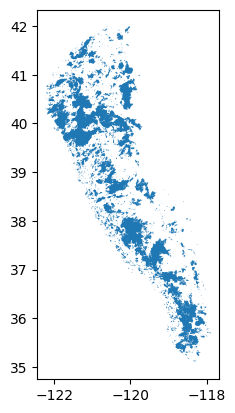

In [117]:
sierra_firep.perimeters.plot()

<Axes: >

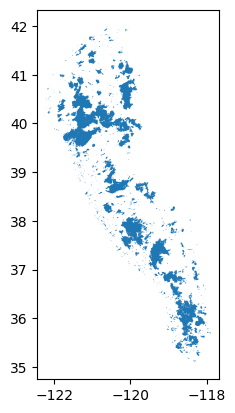

In [118]:
firep.plot()

In [8]:
# Filter out bad or out-of-range data points.
firep = sierra_firep.perimeters.dropna(subset=['ALARM_DATE', 'CONT_DATE', 'FIRE_NAME'])
firep = firep[firep.FIRE_NAME != 'W-4 TERMO']
firep = firep[firep.FIRE_NAME != 'BEALE2']
firep = firep[firep.ALARM_DATE > '1984']
firep = firep[firep.ALARM_DATE < '2022']

In [25]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_9(3)

In [80]:
regen_gedi_per_burn_year = regen_analysis.process_all_fires_with_rf_control_per_burn_year()

Process fires for year 1989.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1990.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1991.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1992.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1993.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1994.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1995.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1996.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1997.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1998.
matching shots within fire
Processi

In [82]:
regen_gedi_per_burn_year['rel_agbd'] = regen_gedi_per_burn_year.agbd / regen_gedi_per_burn_year.agbd_control

In [94]:
regen_gedi_per_burn_year.shape[0]

191509

In [96]:
regen_pft_1 = regen_gedi_per_burn_year[regen_gedi_per_burn_year.pft_class == 1]

In [98]:
fire_cats_pft_1 = gedi_pipeline.add_time_since_burn_categories_5(regen_pft_1)

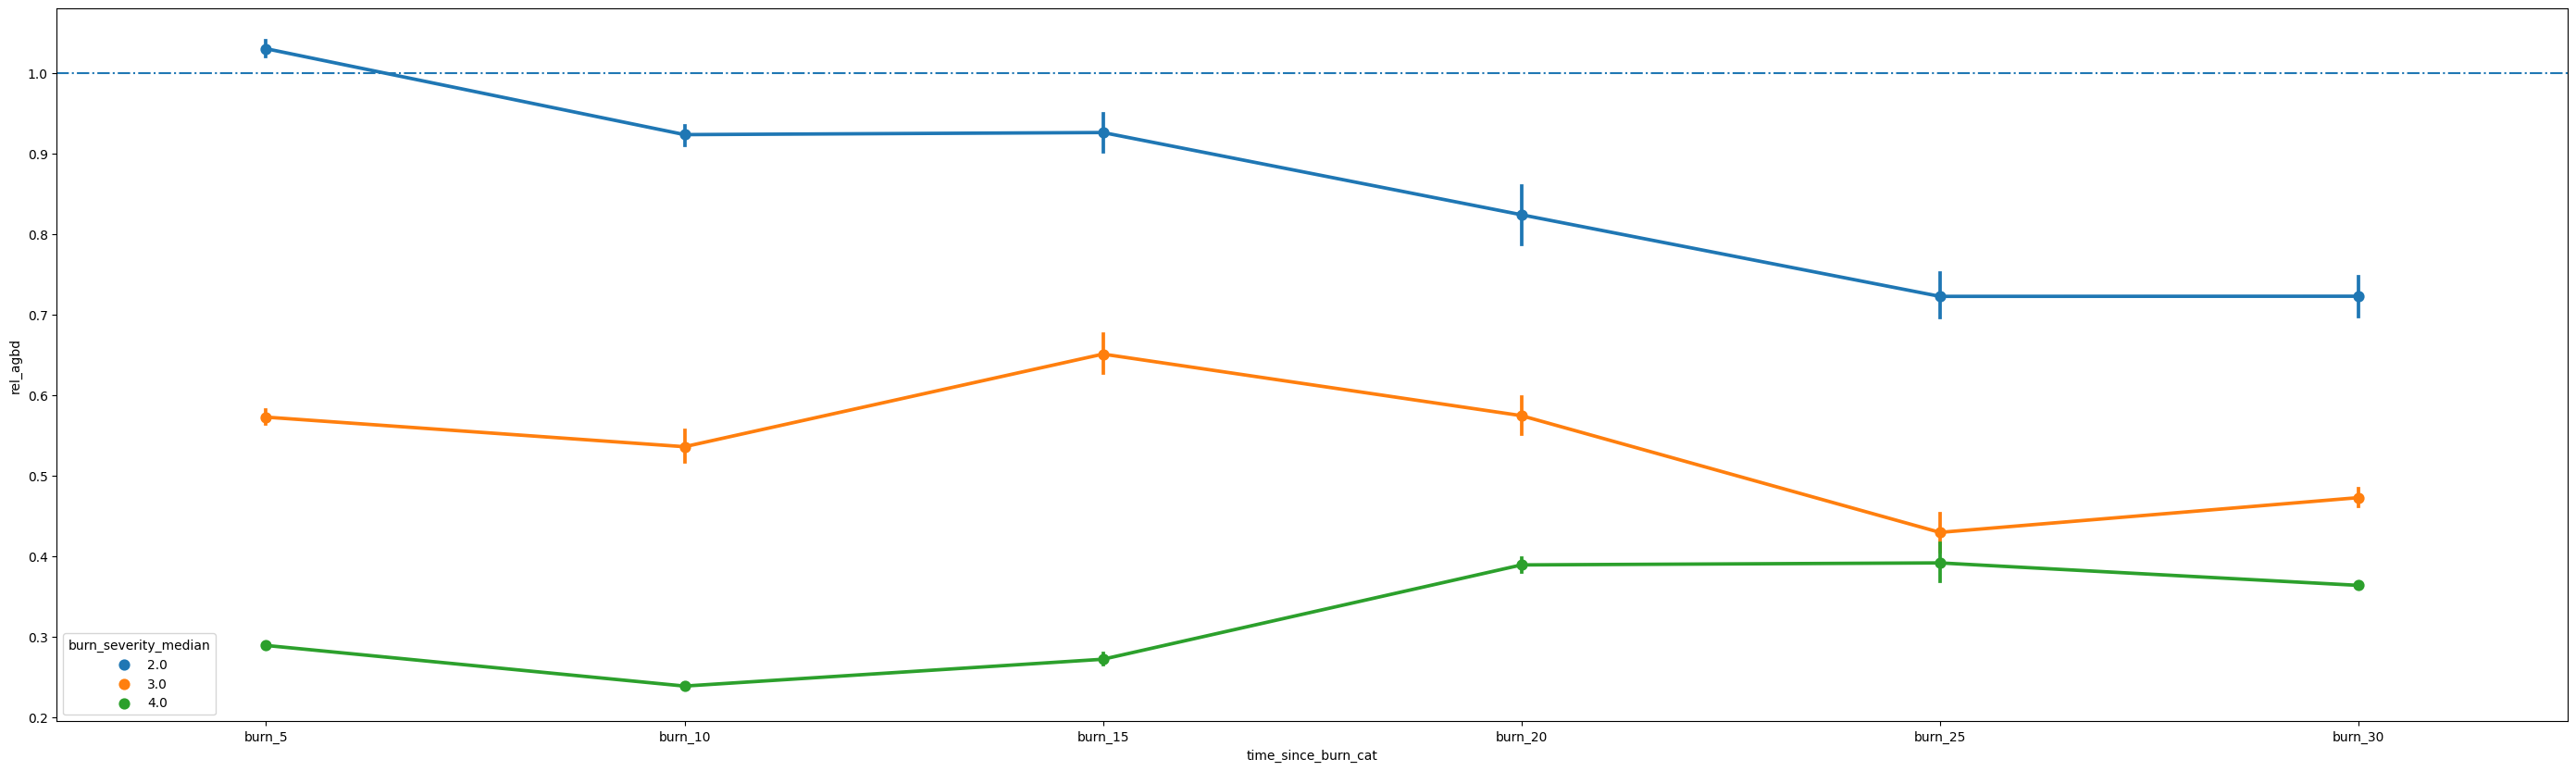

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(fire_cats_pft_1, x='time_since_burn_cat', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

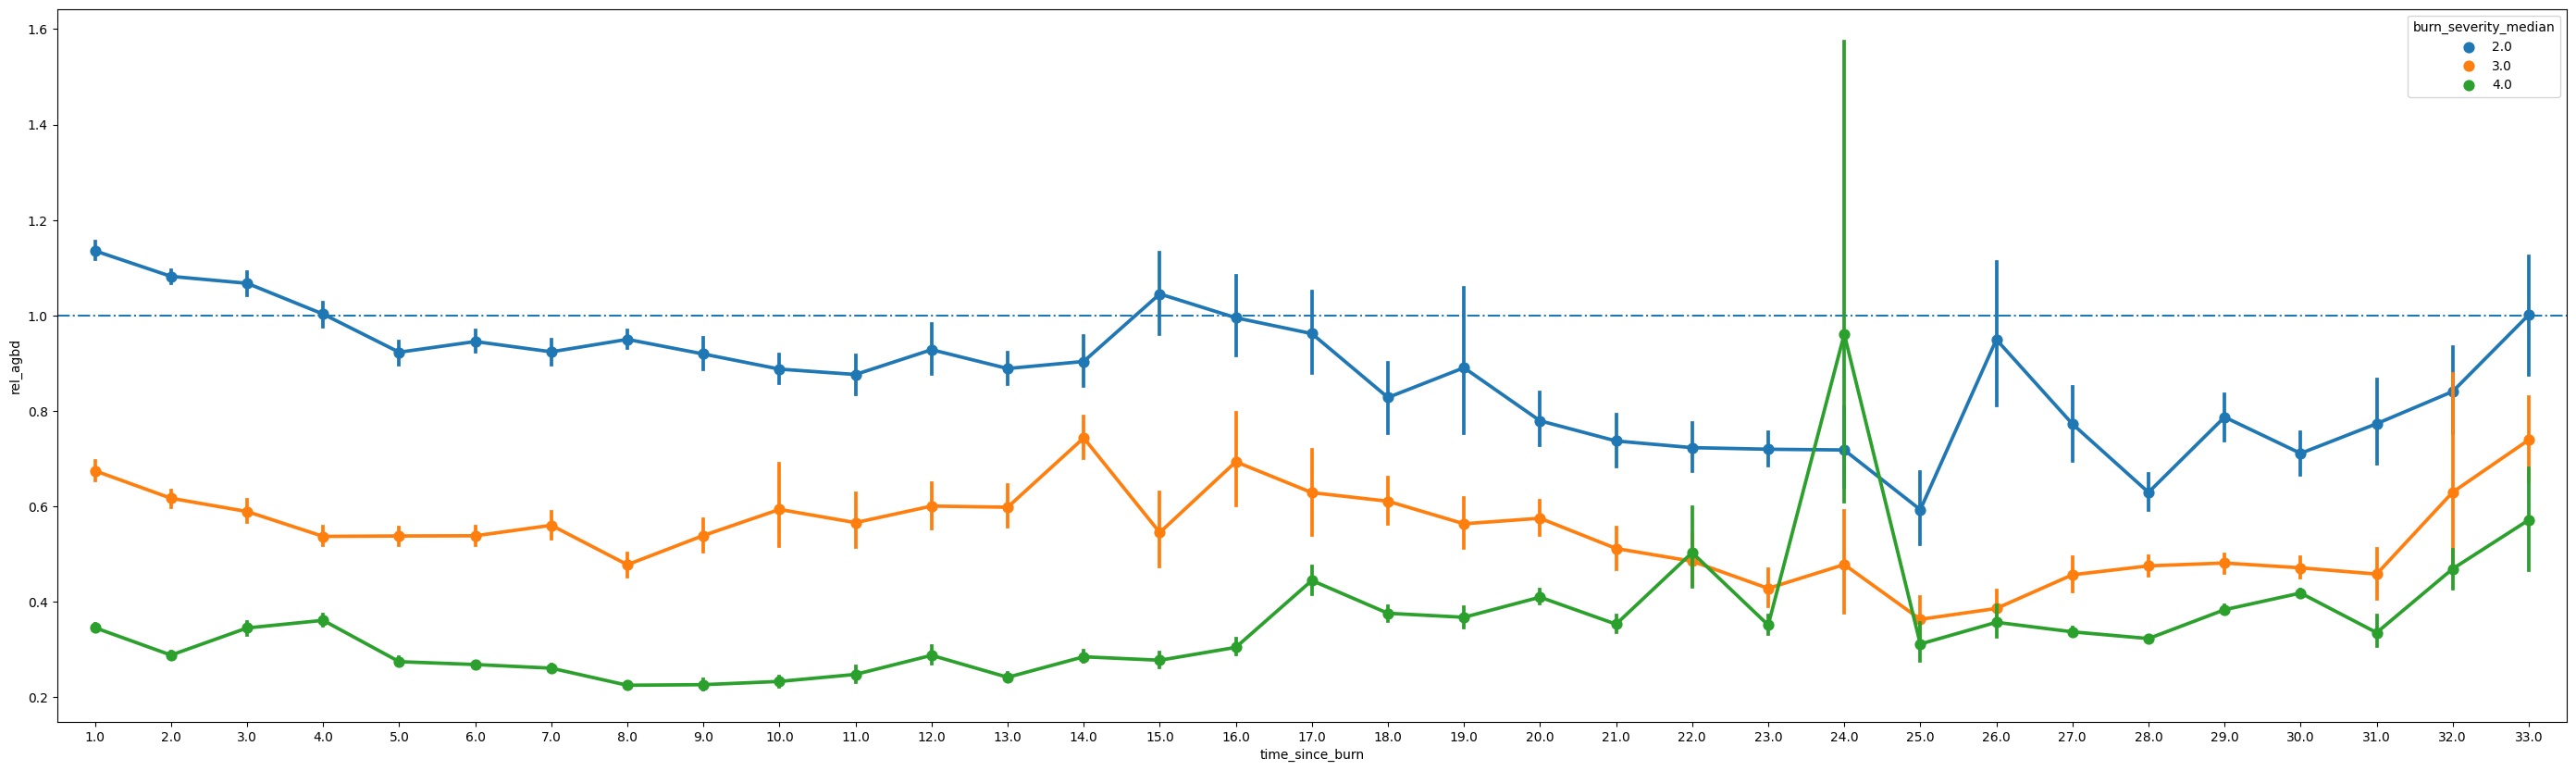

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(regen_pft_1, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

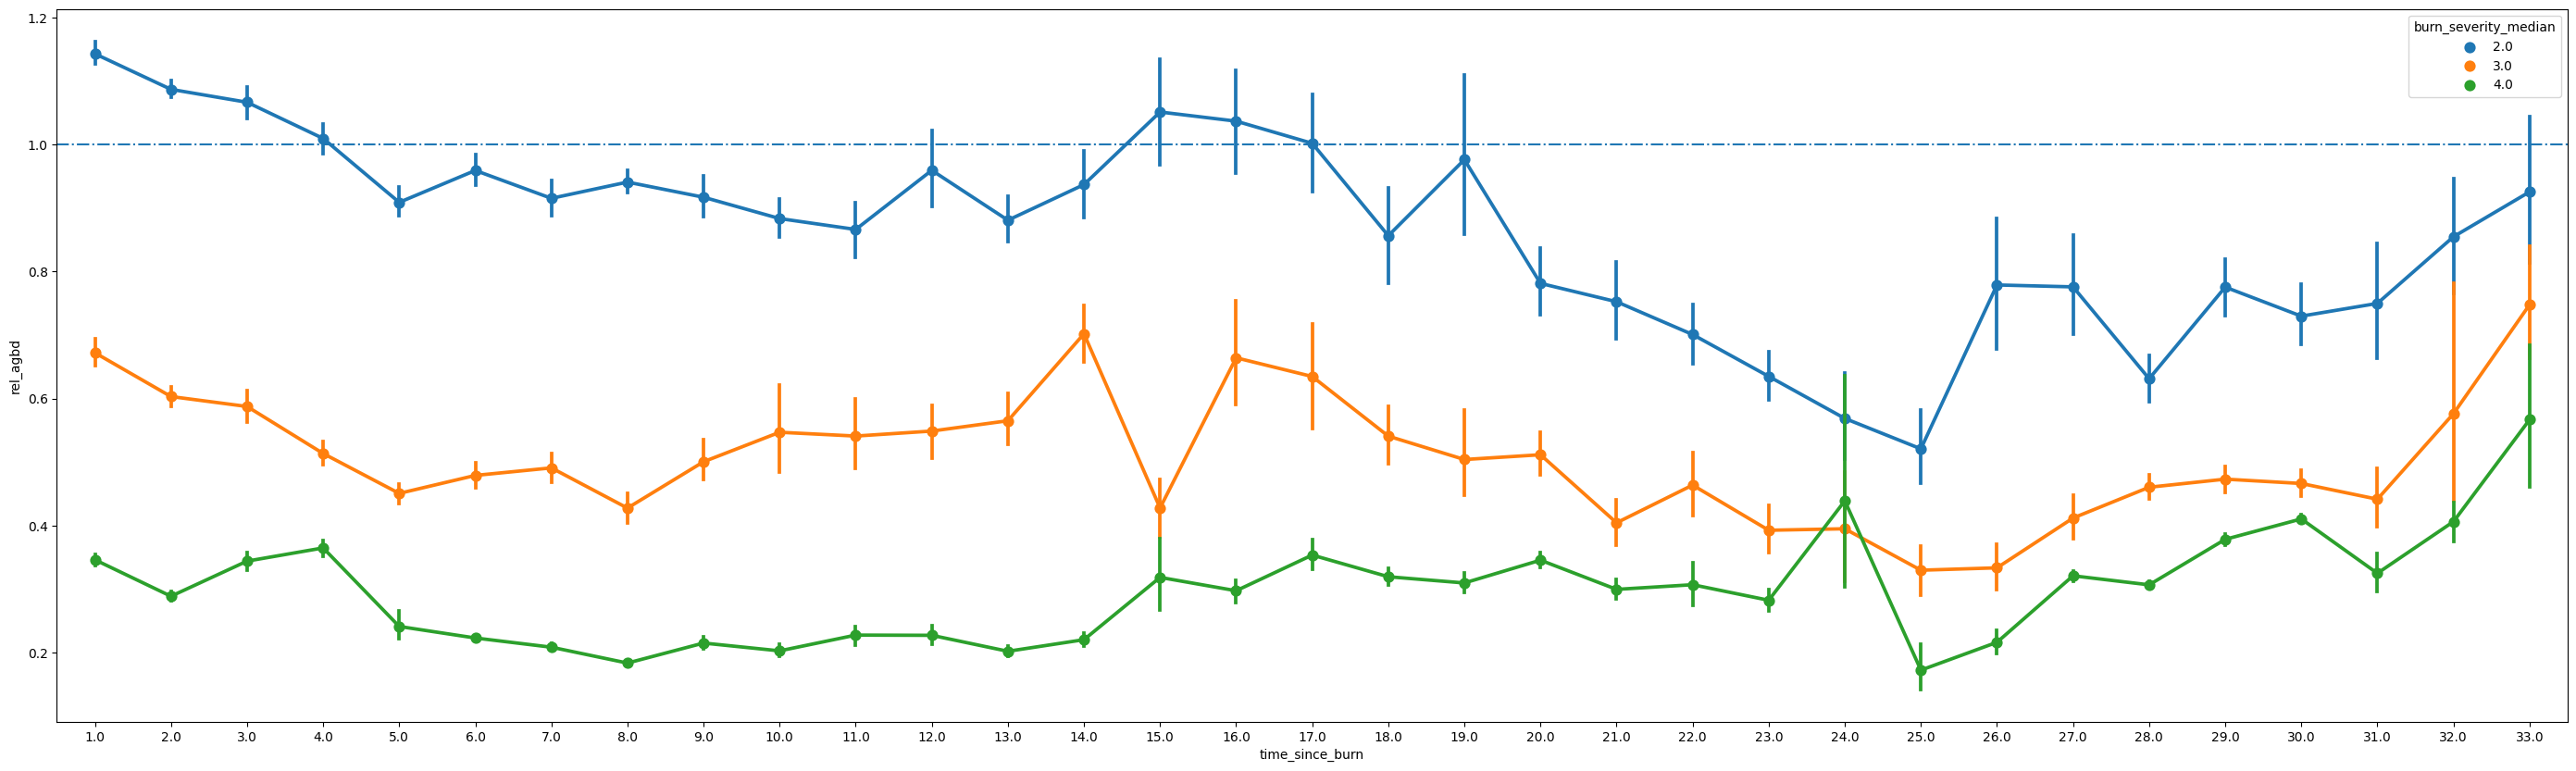

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(regen_gedi_per_burn_year, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

In [92]:
fire_cats = gedi_pipeline.add_time_since_burn_categories_5(regen_gedi_per_burn_year)

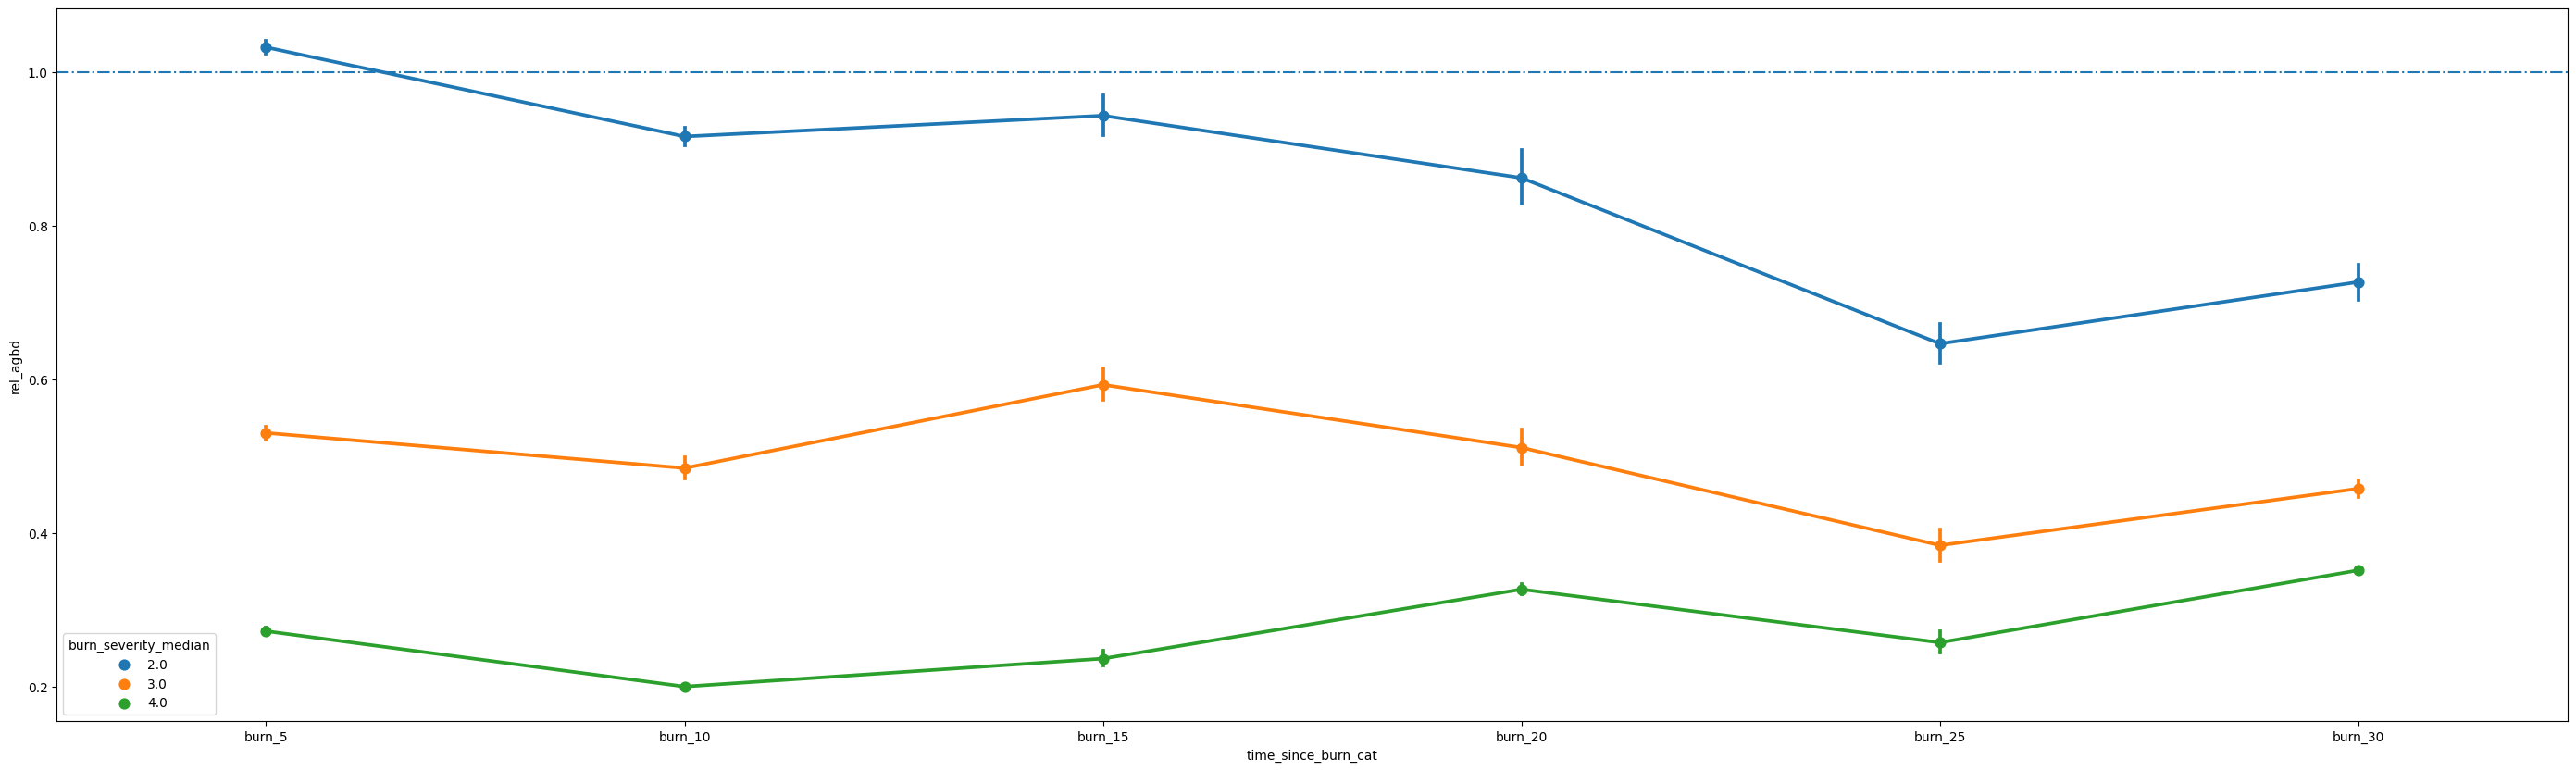

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(fire_cats, x='time_since_burn_cat', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

43601


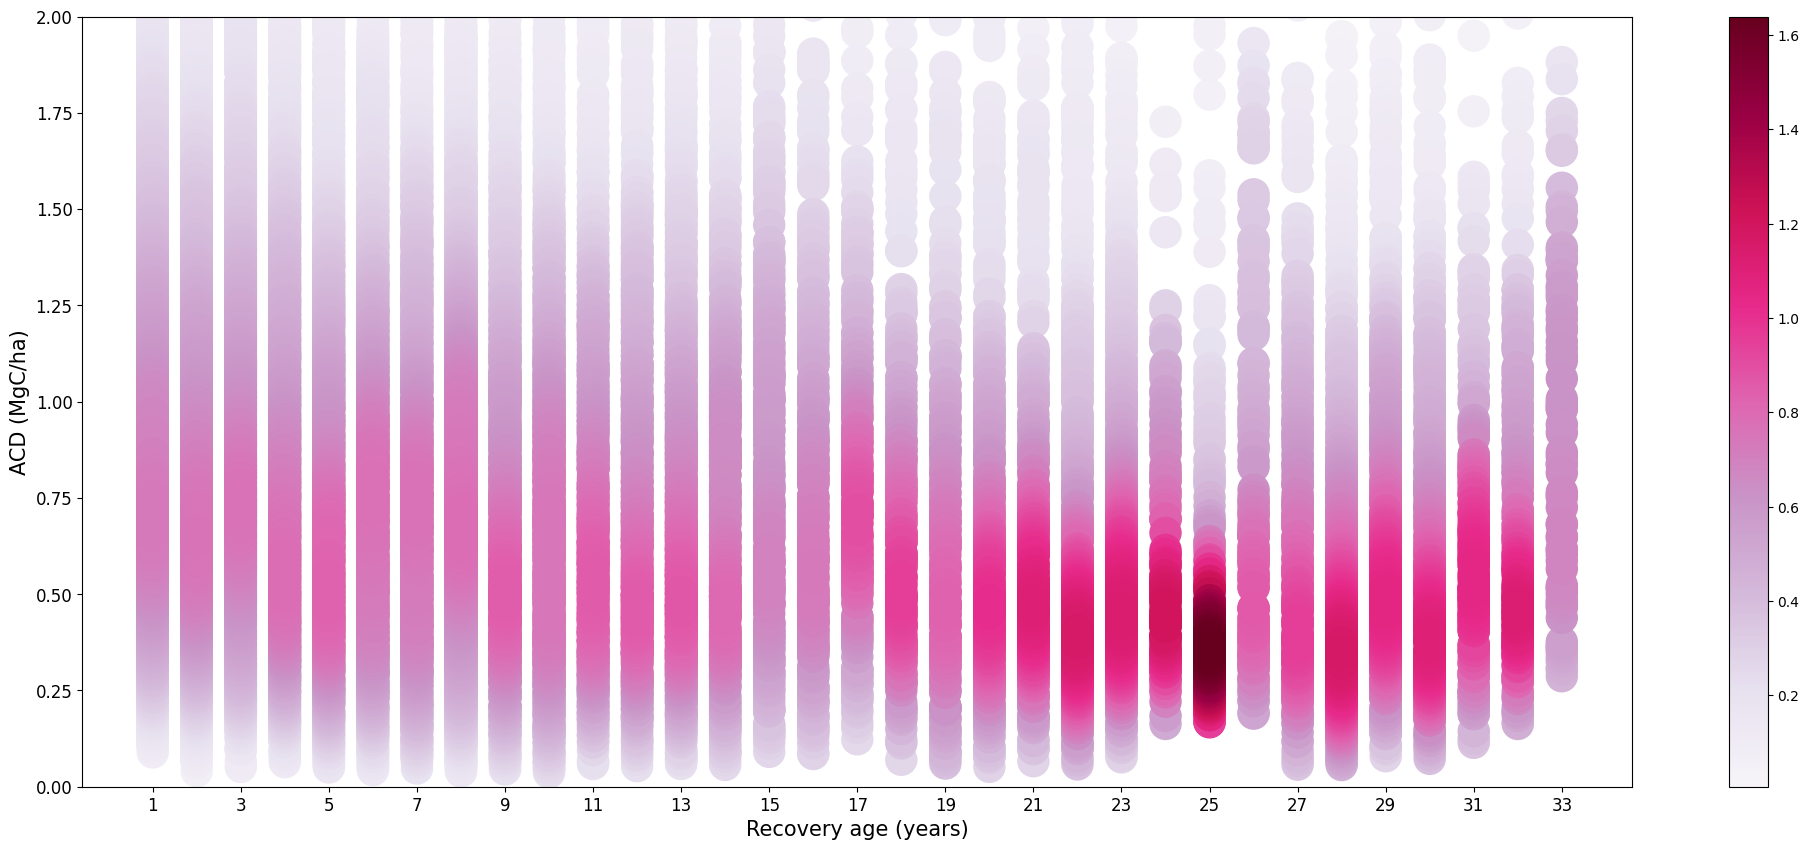

In [100]:

plot_pdf(fire_cats_pft_1[(fire_cats_pft_1.burn_severity_median == 2) & (fire_cats_pft_1.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

49095


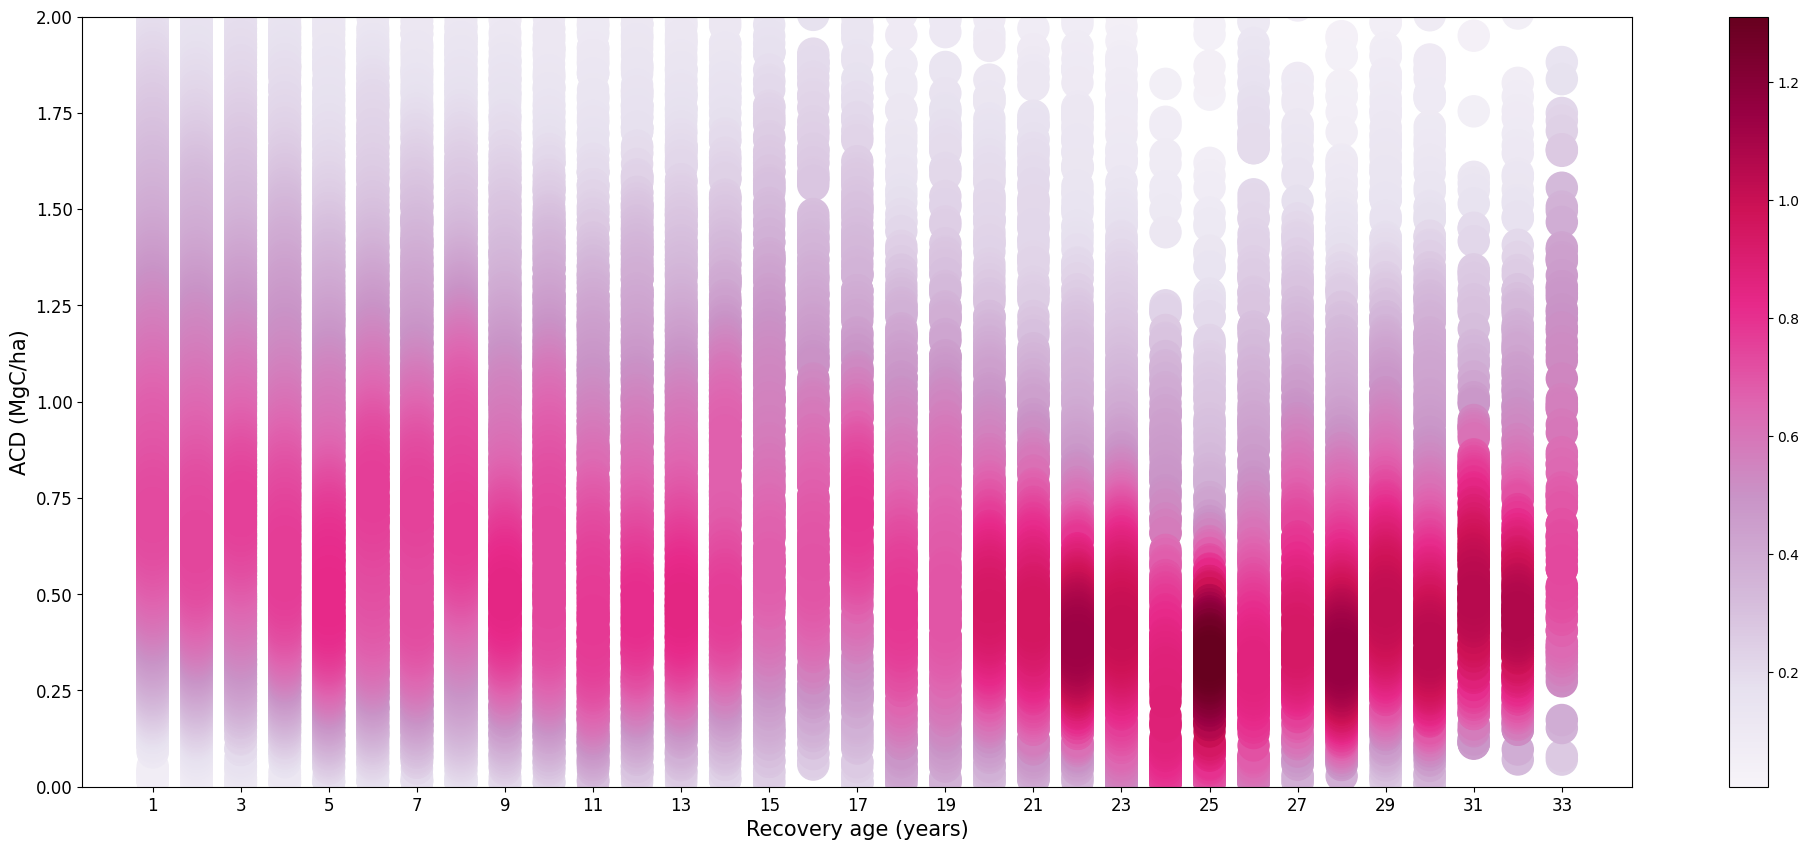

In [86]:
plot_pdf(regen_gedi_per_burn_year[(regen_gedi_per_burn_year.burn_severity_median == 2) & (regen_gedi_per_burn_year.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

24211


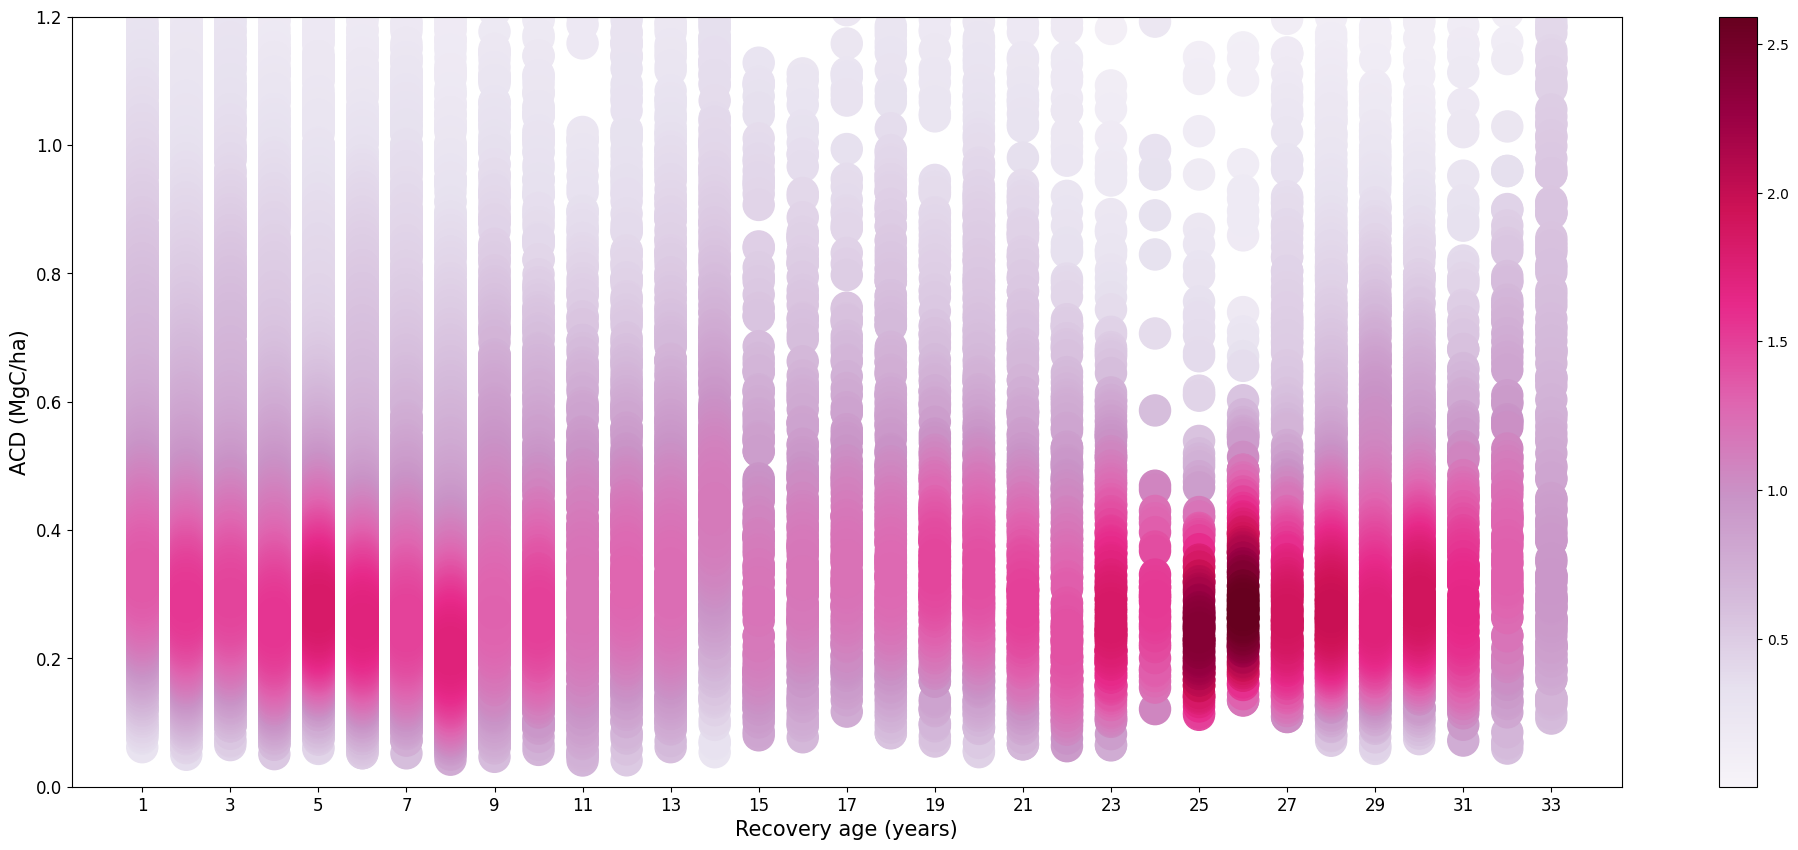

In [101]:

plot_pdf(fire_cats_pft_1[(fire_cats_pft_1.burn_severity_median == 3) & (fire_cats_pft_1.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1.2))

30568


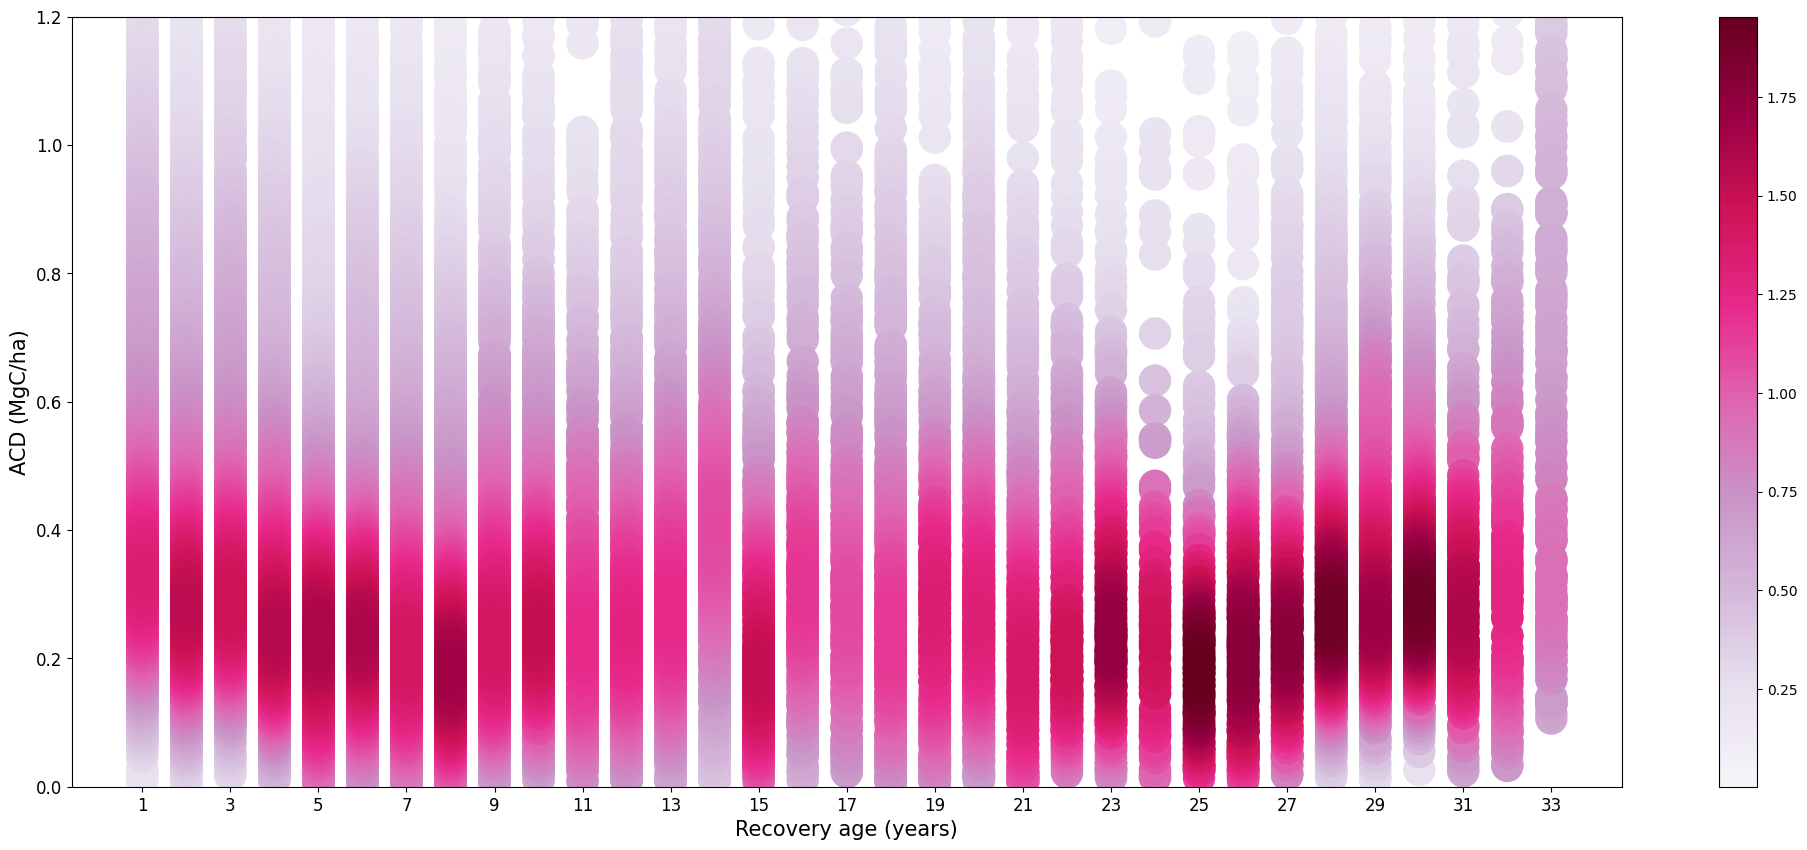

In [88]:
plot_pdf(regen_gedi_per_burn_year[(regen_gedi_per_burn_year.burn_severity_median == 3) & (regen_gedi_per_burn_year.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1.2))

85235


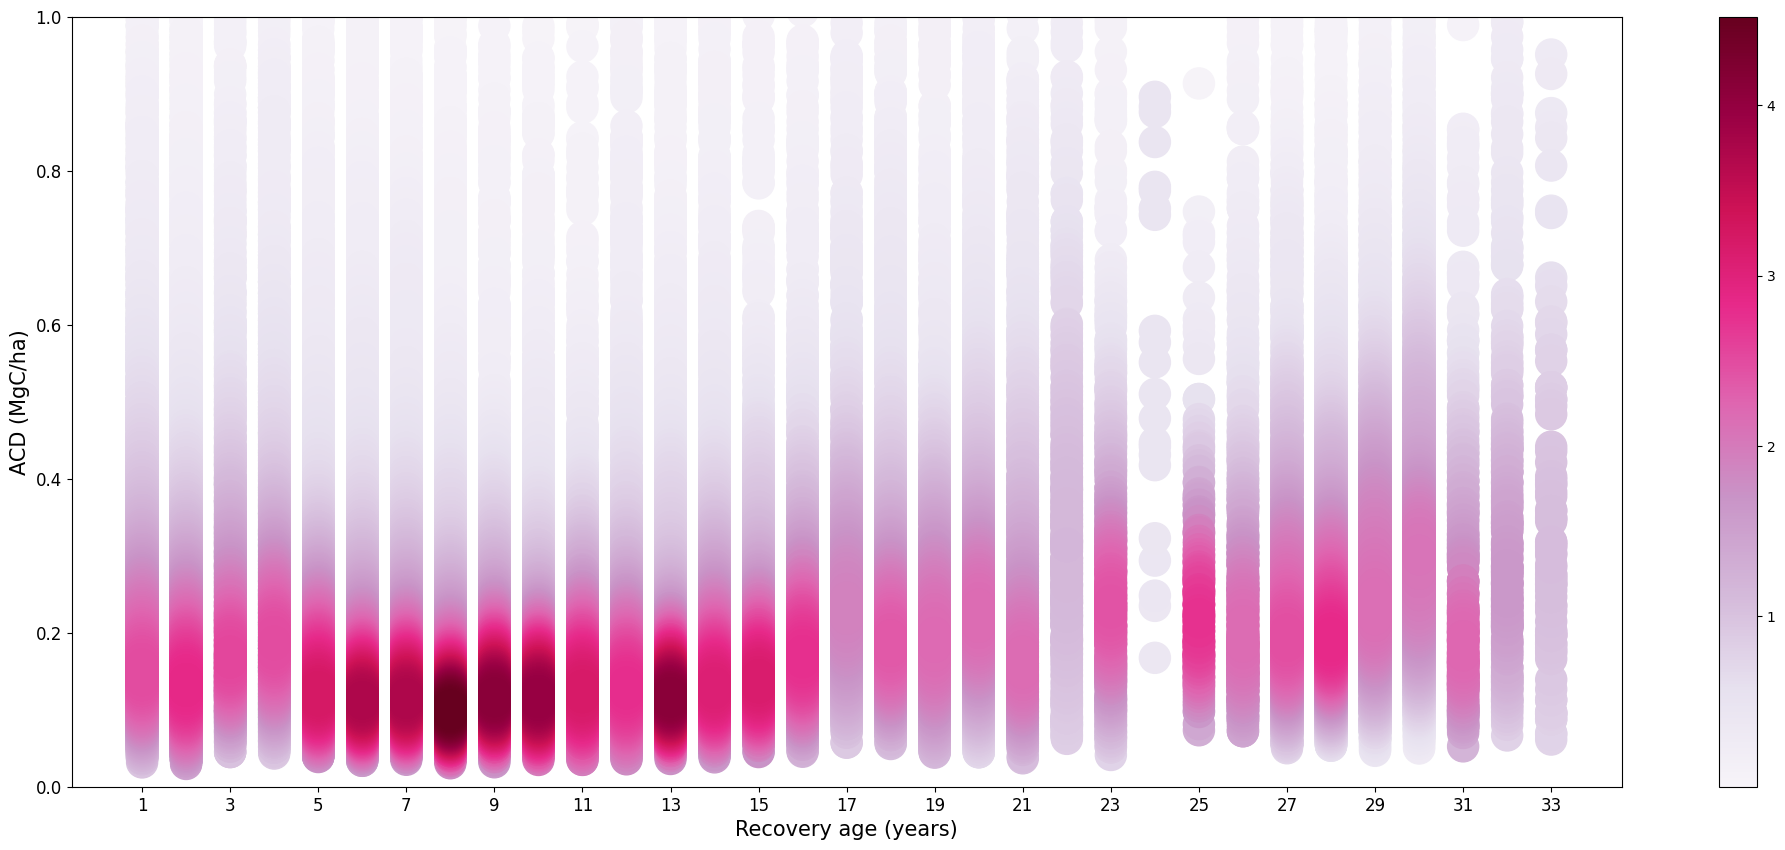

In [102]:

plot_pdf(fire_cats_pft_1[(fire_cats_pft_1.burn_severity_median == 4)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1))

110819


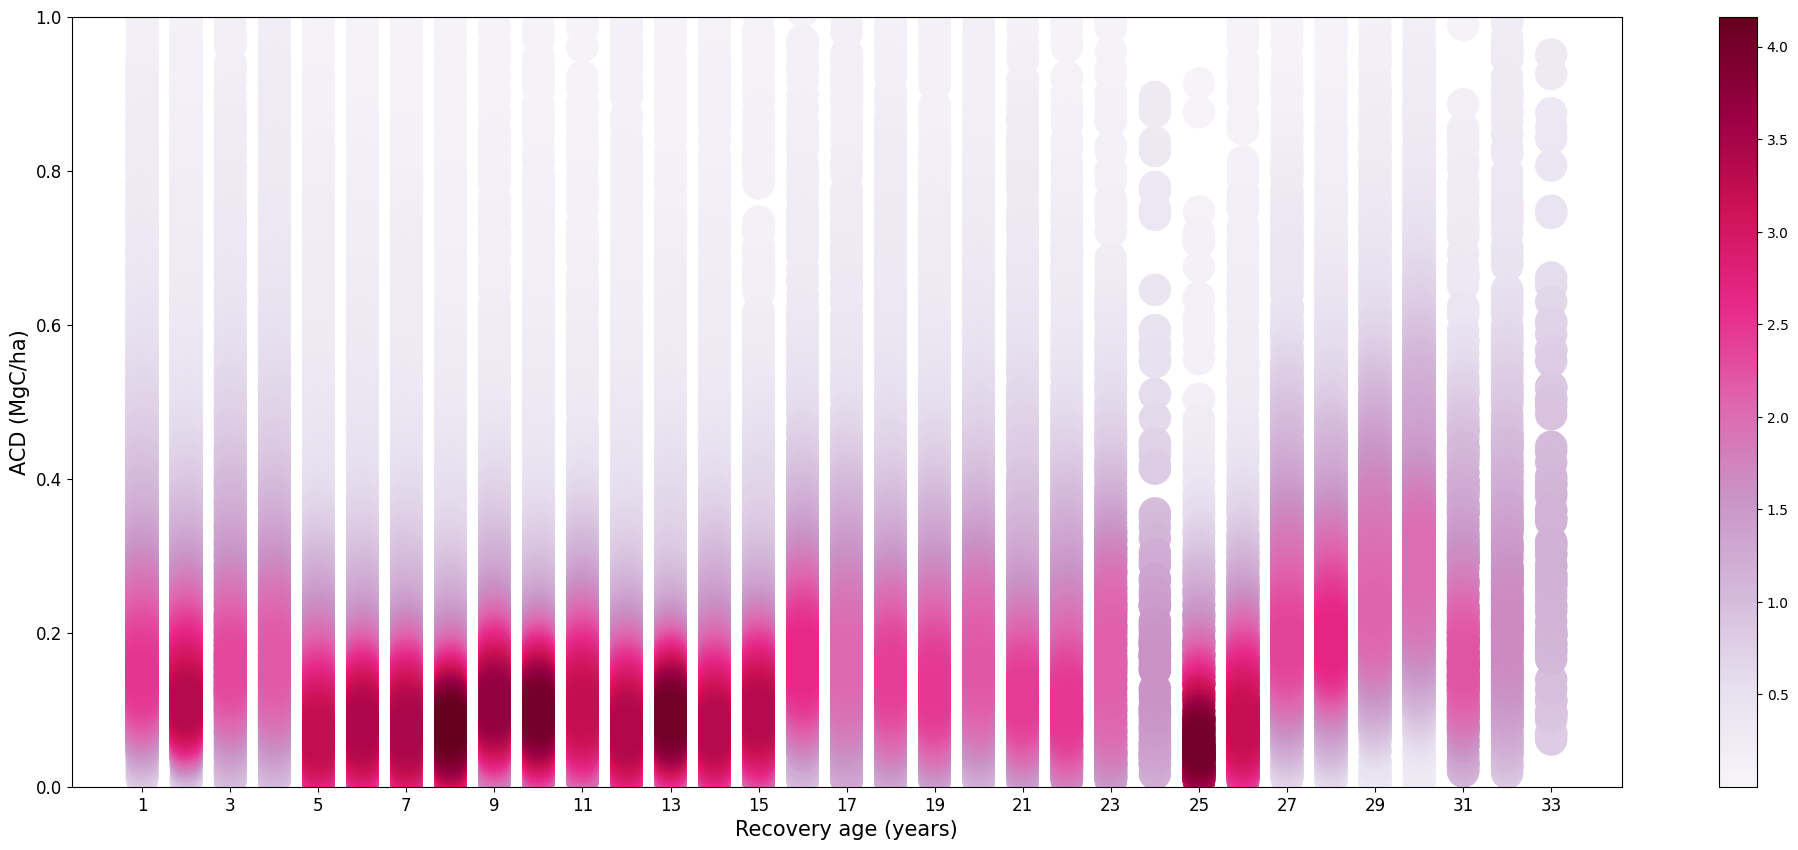

In [89]:
plot_pdf(regen_gedi_per_burn_year[(regen_gedi_per_burn_year.burn_severity_median == 4) & (regen_gedi_per_burn_year.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1))

In [84]:
save_pickle(f"{DATA_PATH}/rf/results/gedi_3x3_match_per_burn_year.pkl", regen_gedi_per_burn_year)

In [28]:
gedi_burned[(gedi_burned.land_cover_std == 0) & (gedi_burned.land_cover_median == 1)]

shot_number   longitude   latitude        agbd  \
226043     52520500200220883 -120.898718  41.857705   56.699760   
226155    174711100300205220 -120.895451  41.862932    0.919862   
226156    174711100300205222 -120.894334  41.862338   54.759003   
266370     64421100200220563 -120.903260  41.866773   43.625595   
266372     64421100200220566 -120.901583  41.867660   42.969738   
...                      ...         ...        ...         ...   
10739573  174560500300291197 -118.588123  36.811295  605.784363   
10739681   76920800200086263 -118.581961  36.805782   57.823112   
10748046  174560300300291379 -118.561519  36.803085  101.434074   
13920456  103610200200193053 -118.569528  36.824070   46.596722   
13920460  103610200200193057 -118.567627  36.825404   40.198425   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
226043        21.643114     108.318810   2.995990      full     0.966562   
226155     -9999.000000      14.765323   3.008004      full     0.970312   
226156        20.456135     105.617134   2.994695      full     0.970751   
266370        13.920637      89.849503   2.988128      full     0.957030   
266372        13.552419      88.904152   2.987793      full     0.961133   
...                 ...            ...        ...       ...          ...   
10739573     458.516968     773.527588   3.703897      full     0.961634   
10739681      22.335781     109.877083   2.996756      full     0.957344   
10748046      21.057505     241.928513  11.099751  coverage     0.962761   
13920456       1.802333     151.532364  11.104068  coverage     0.970274   
13920460       0.733710     139.804062  11.104008  coverage     0.973113   

          pft_class  ...  burn_counts_median  time_since_burn  \
226043            6  ...                 1.0              2.0   
226155            6  ...                 1.0              5.0   
226156            6  ...                 1.0              5.0   
266370            6  ...                 1.0              3.0   
266372            6  ...                 1.0              3.0   
...             ...  ...                 ...              ...   
10739573          6  ...                 1.0             29.0   
10739681          6  ...                 1.0             27.0   
10748046          1  ...                 1.0             29.0   
13920456          1  ...                 1.0             27.0   
13920460          1  ...                 1.0             27.0   

               land_cover_3x3 land_cover_mean  land_cover_std  \
226043    [1 1 1 1 1 1 1 1 1]             1.0             0.0   
226155    [1 1 1 1 1 1 1 1 1]             1.0             0.0   
226156    [1 1 1 1 1 1 1 1 1]             1.0             0.0   
266370    [1 1 1 1 1 1 1 1 1]             1.0             0.0   
266372    [1 1 1 1 1 1 1 1 1]             1.0             0.0   
...                       ...             ...             ...   
10739573  [1 1 1 1 1 1 1 1 1]             1.0             0.0   
10739681  [1 1 1 1 1 1 1 1 1]             1.0             0.0   
10748046  [1 1 1 1 1 1 1 1 1]             1.0             0.0   
13920456  [1 1 1 1 1 1 1 1 1]             1.0             0.0   
13920460  [1 1 1 1 1 1 1 1 1]             1.0             0.0   

          land_cover_median    elevation      slope      aspect  soil  
226043                  1.0  1514.666667   1.666667  166.000000   0.0  
226155                  1.0  1532.000000   2.000000  170.000000   0.0  
226156                  1.0  1531.000000   1.777778  180.222222   0.0  
266370                  1.0  1547.222222   2.333333  172.555556   0.0  
266372                  1.0  1553.444444   2.888889  195.333333   0.0  
...                     ...          ...        ...         ...   ...  
10739573                1.0  2334.333333  29.000000  100.000000   0.0  
10739681                1.0  1923.333333  29.000000  109.666667   0.0  
10748046                1.0  2452.888889  27.111111  272.000000   0.0  
13920456         

In [61]:
gedi_regen = regen_analysis.process_all_fires_with_rf_control(firep)

Process fires for year 1989.
Processing fire EAGLE and 7052
matching shots within fire
Calculate distance to perimeter.
Processing data
Run RF to predict control AGBD.
Processing fire   and 11491
matching shots within fire
No matches for fire  .
Processing fire CHALK and 11503
matching shots within fire
No matches for fire CHALK.
Processing fire DEVIL and 11504
matching shots within fire
No matches for fire DEVIL.
Processing fire   and 11984
matching shots within fire
No matches for fire  .
Processing fire   and 12910
matching shots within fire
No matches for fire  .
Processing fire   and 12911
matching shots within fire
No matches for fire  .
Processing fire   and 12912
matching shots within fire
No matches for fire  .
Processing fire   and 12913
matching shots within fire
Calculate distance to perimeter.
Processing data
Run RF to predict control AGBD.
Processing fire LAYMAN and 12915
matching shots within fire
Calculate distance to perimeter.
Processing data
Run RF to predict control

In [104]:
gedi_regen_pft_1 = gedi_regen[gedi_regen.pft_class == 1]

In [105]:
gedi_ref_pft_1 = gedi_regen_pft_1.astype({'YEAR_': 'float64'})

In [66]:
gedi_ref = gedi_regen.astype({'YEAR_': 'float64'})

In [70]:
gedi_certain = gedi_ref[(gedi_ref.burn_year_median == gedi_ref.YEAR_)]

In [119]:
gedi_ref.shape[0]

163588

In [108]:
gedi_certain.shape[0]

160441

In [106]:
gedi_certain_pft_1 = gedi_ref_pft_1[(gedi_ref_pft_1.burn_year_median == gedi_ref_pft_1.YEAR_)]
gedi_certain_pft_1.shape[0]

127513

In [73]:
gedi_certain['rel_agbd'] = gedi_certain.agbd / gedi_certain.agbd_control

In [107]:
gedi_certain_pft_1['rel_agbd'] = gedi_certain_pft_1.agbd / gedi_certain_pft_1.agbd_control

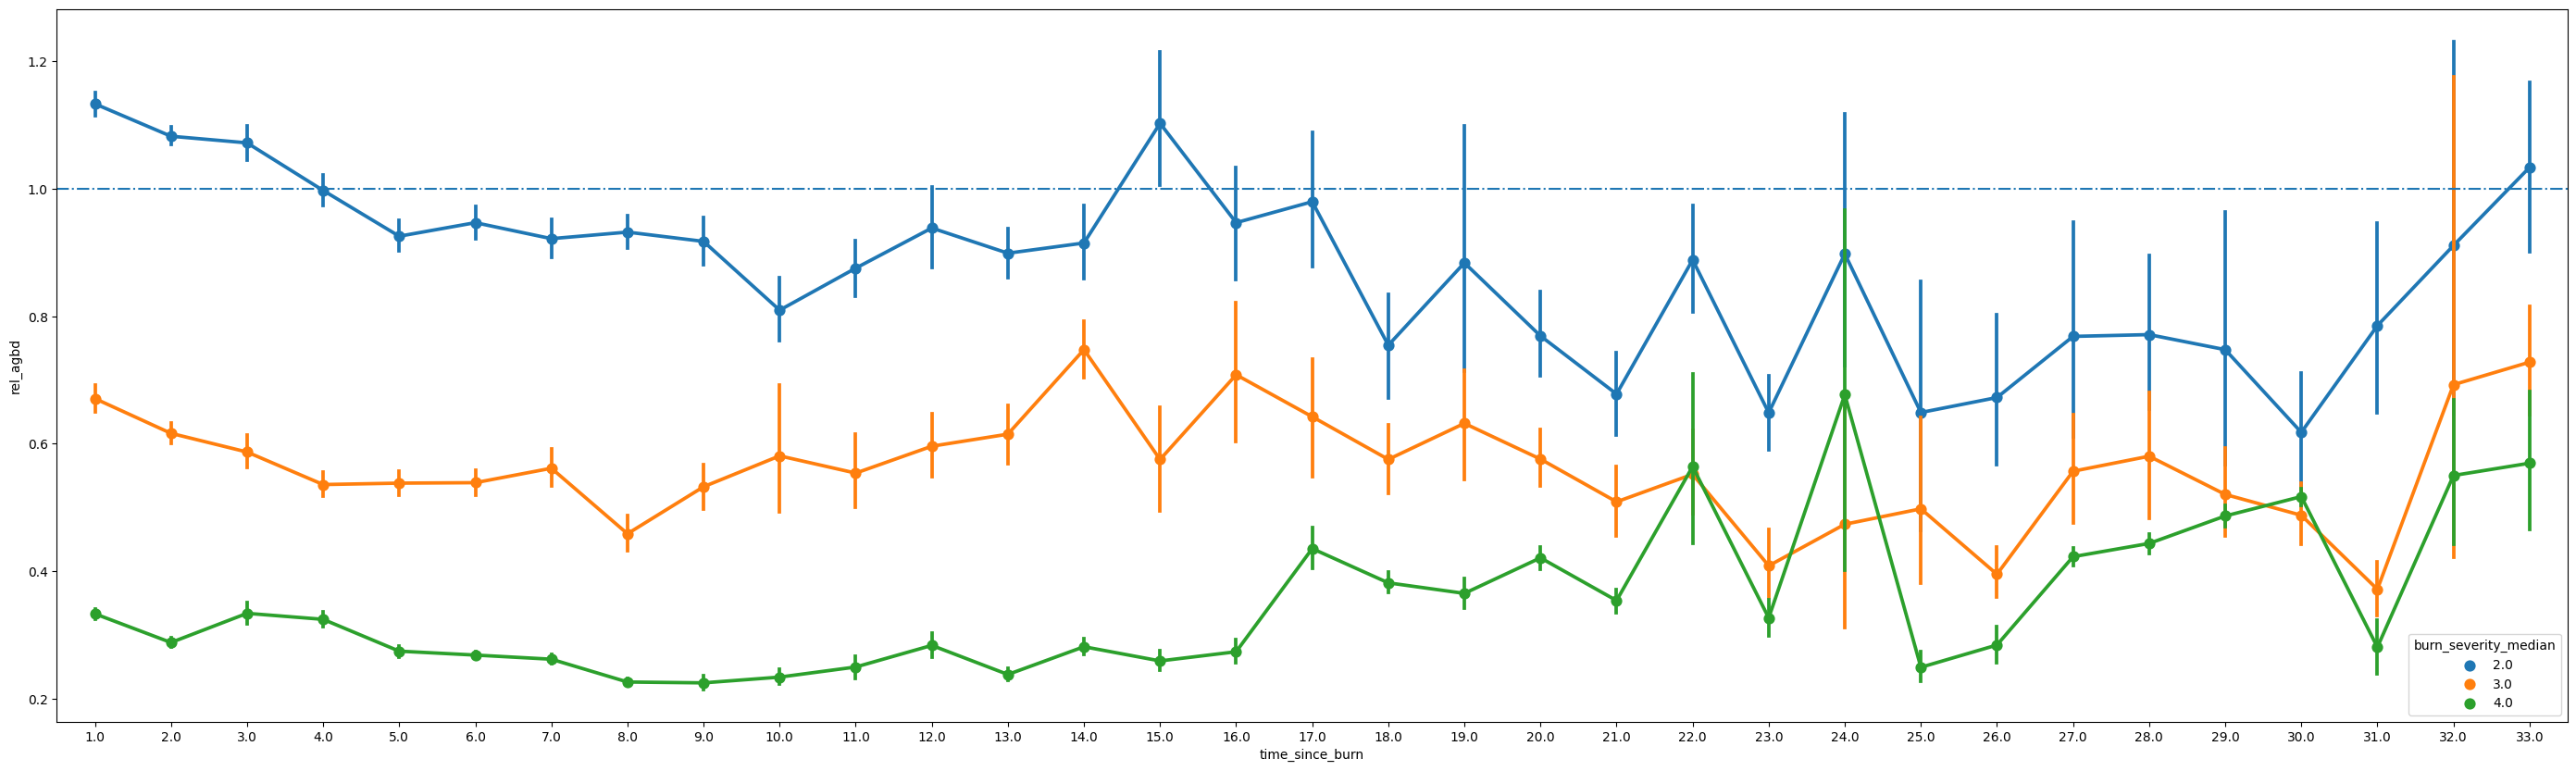

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_certain_pft_1, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

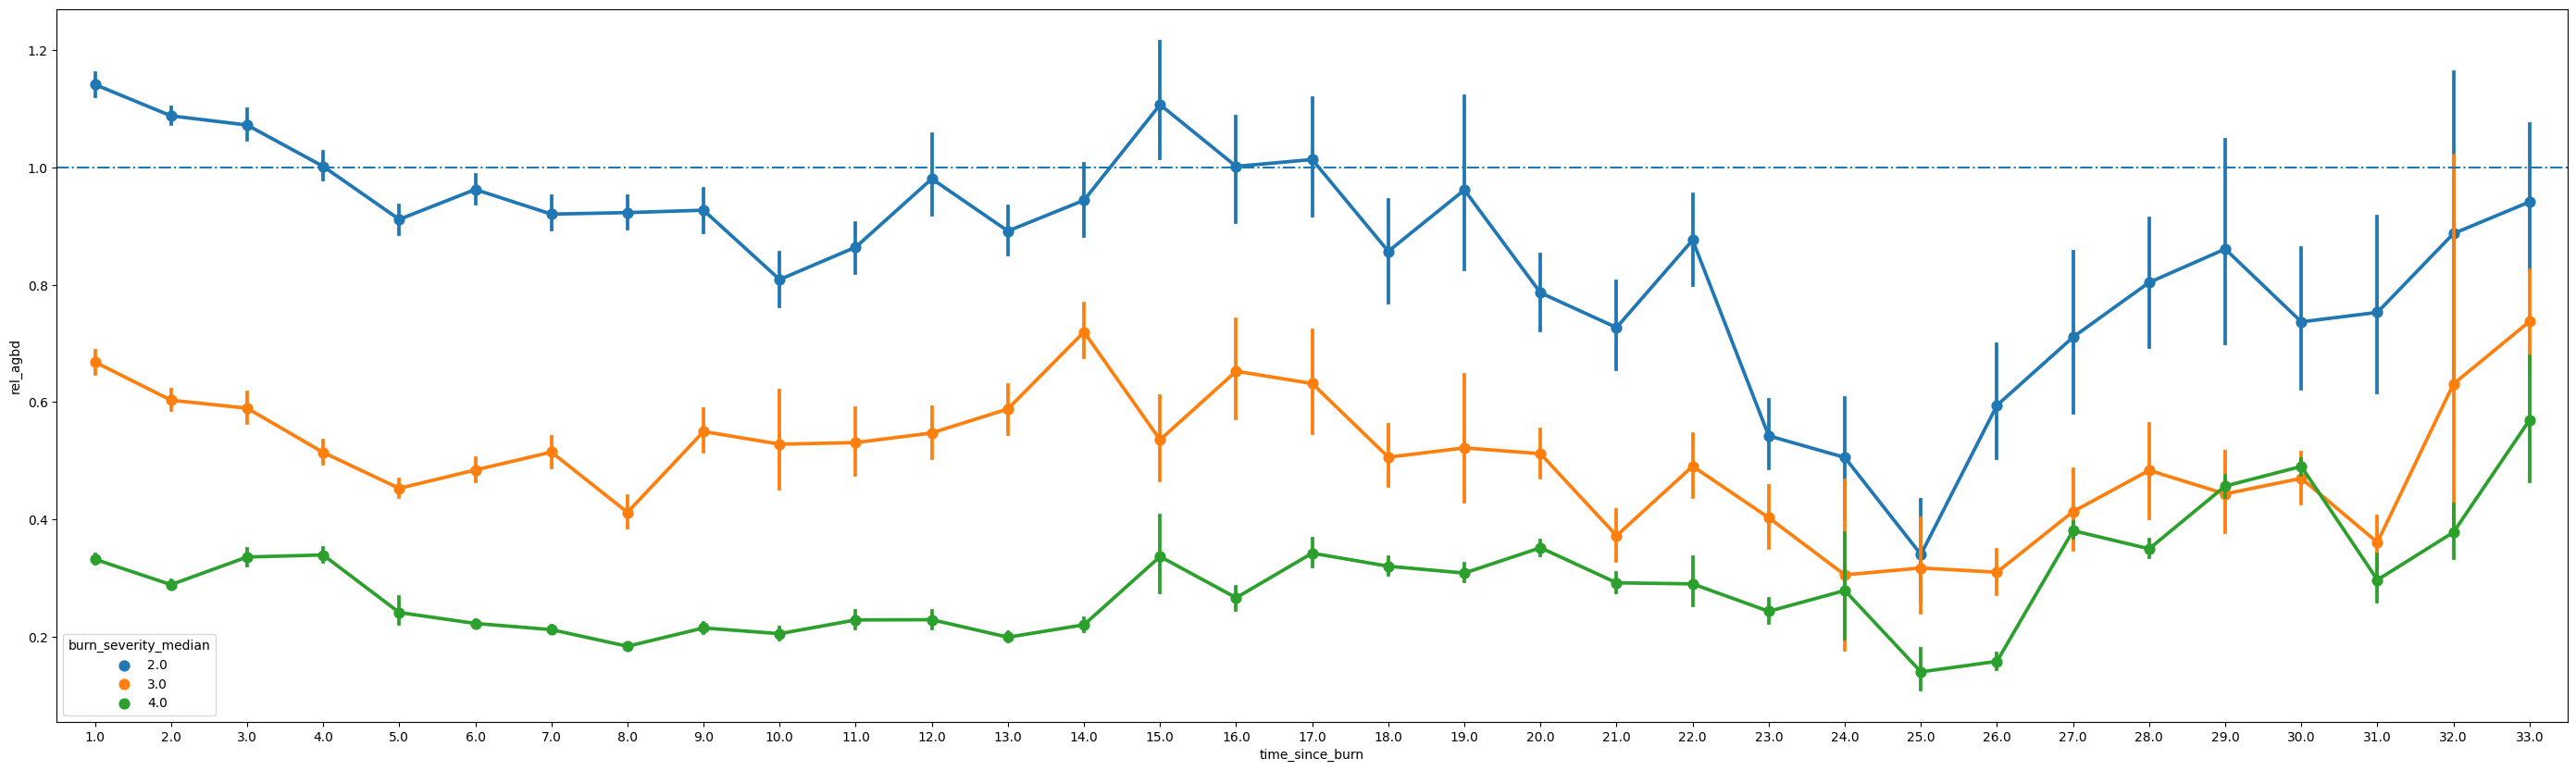

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_certain, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')
ax.axhline(y=1, linestyle="-.")

94377


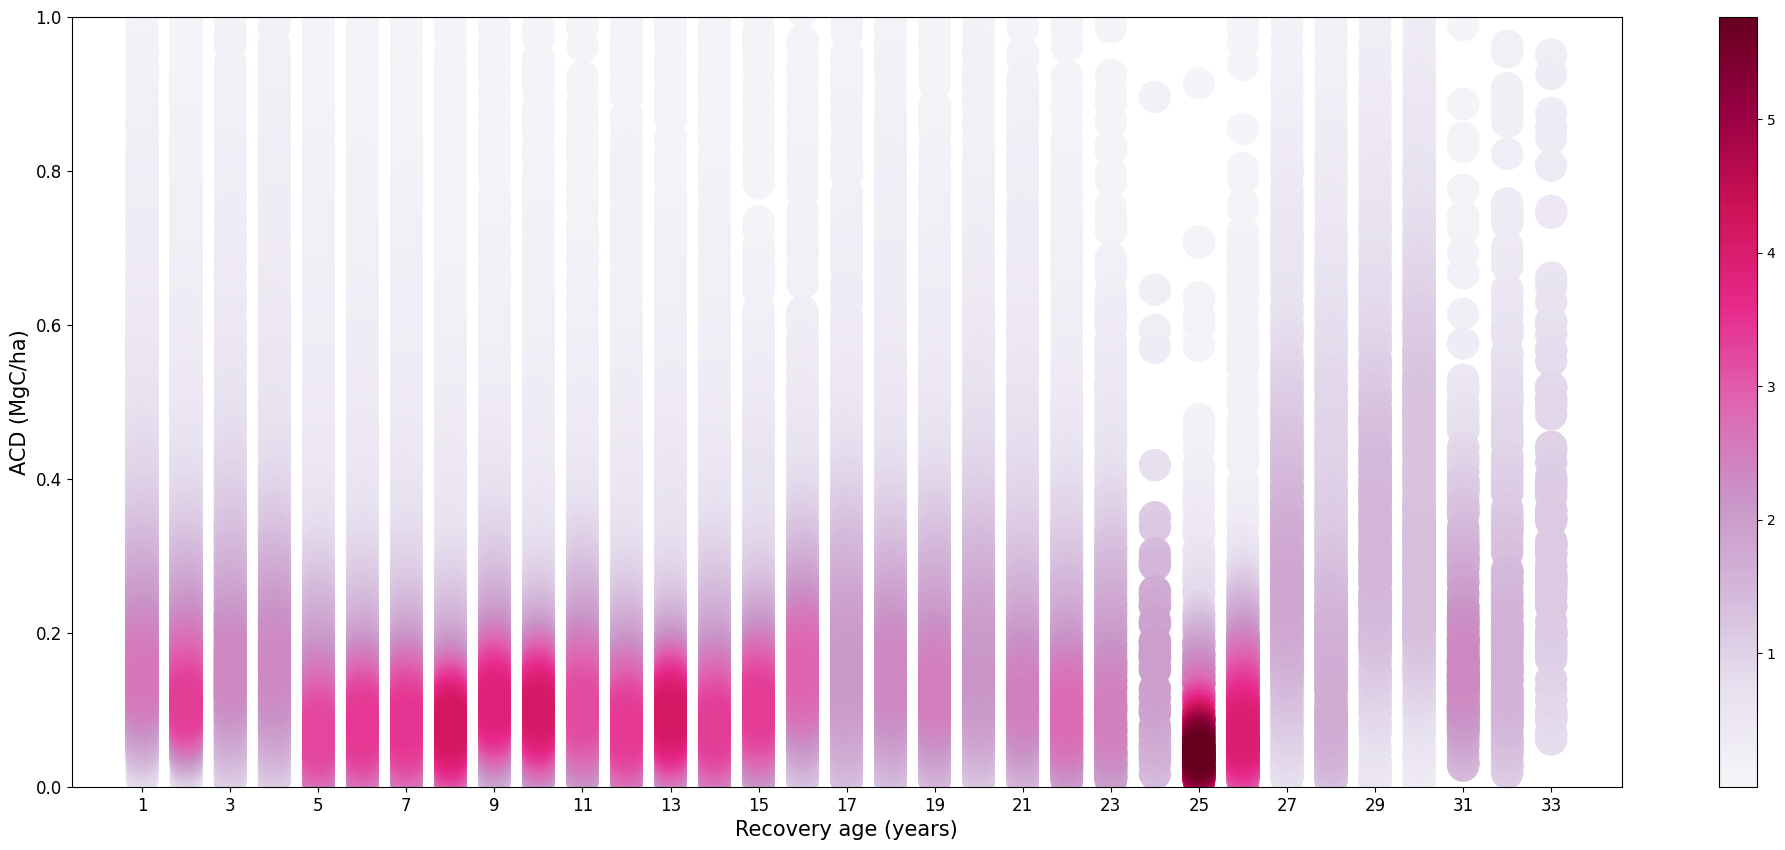

In [90]:
plot_pdf(gedi_certain[(gedi_certain.burn_severity_median == 4) & (gedi_certain.rel_agbd < 3)],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1))

In [76]:
save_pickle(f"{DATA_PATH}/rf/results/gedi_3x3_match_per_fire.pkl", gedi_certain)

### Fire sizes

<Axes: xlabel='area_acres', ylabel='Count'>

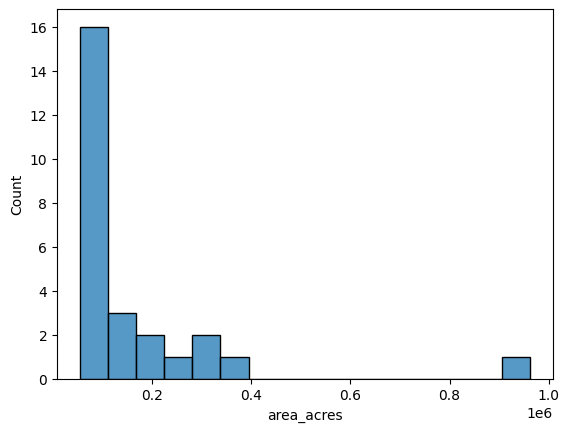

In [55]:
sns.histplot(firep[firep.area_acres > 50000], x="area_acres")

<Axes: xlabel='area_acres', ylabel='Count'>

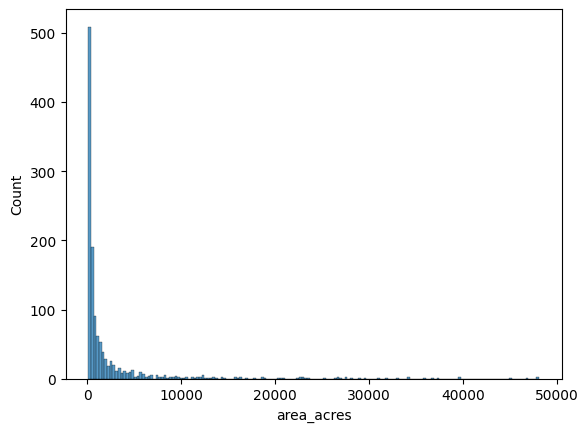

In [56]:
sns.histplot(firep[(firep.area_acres > 100) & ((firep.area_acres < 50000) )], x="area_acres")

In [58]:
firep[(firep.area_acres > 1000) & ((firep.area_acres < 50000))].to_csv(f"{DATA_PATH}/controls/fire_areas_1000_to_50000.csv")

<Axes: xlabel='area_acres', ylabel='Count'>

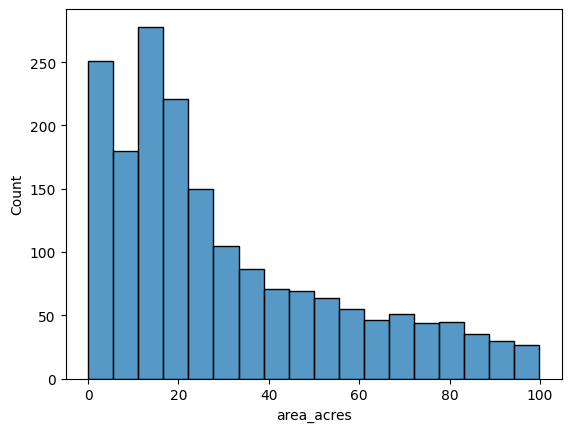

In [44]:
sns.histplot(firep[firep.area_acres < 100], x="area_acres")

In [25]:
firep.sort_values('area_acres', ascending=False)

YEAR_ STATE AGENCY UNIT_ID      FIRE_NAME   INC_NUM  \
21674  2021    CA    CDF     BTU          DIXIE  00009205   
241    2020    CA    USF     SNF          CREEK  00001391   
236    2020    CA    USF     PNF  NORTH COMPLEX  00001308   
17845  2012    CA    BLM     NOD           RUSH  00003490   
18192  2013    CA    USF     STF            RIM  00000006   
...     ...   ...    ...     ...            ...       ...   
19111  2013    CA    NPS     YNP     RICHARDSON  00000133   
19098  2013    CA    NPS     YNP      SNOW PEAK  00000091   
20230  2017    CA    CCO     KRN            MID  01732273   
20401  2017    CA    USF     ENF           MILL  00020010   
17744  2012    CA    CCO     KRN       155 FIRE  01204086   

                      ALARM_DATE                  CONT_DATE  CAUSE  \
21674  2021-07-14T00:00:00+00:00  2021-10-25T00:00:00+00:00   11.0   
241    2020-09-04T00:00:00+00:00  2020-12-24T00:00:00+00:00   14.0   
236    2020-08-17T00:00:00+00:00  2020-12-03T00:00:00+00:00    1.0   
17845  2012-08-12T00:00:00+00:00  2012-10-22T00:00:00+00:00    1.0   
18192  2013-08-17T00:00:00+00:00  2013-10-24T00:00:00+00:00    4.0   
...                          ...                        ...    ...   
19111  2013-09-21T00:00:00+00:00  2013-10-18T00:00:00+00:00    1.0   
19098  2013-07-20T00:00:00+00:00  2013-10-18T00:00:00+00:00    1.0   
20230  2017-08-15T00:00:00+00:00  2017-08-15T00:00:00+00:00   14.0   
20401  2017-07-12T00:00:00+00:00  2017-07-12T00:00:00+00:00    9.0   
17744  2012-02-09T00:00:00+00:00  2012-02-09T00:00:00+00:00   14.0   

                                                COMMENTS  ...  C_METHOD  \
21674  E9DB628D-DFB7-4C85-BCD6-1254574D946B, contains...  ...       7.0   
241                 33CBB9DC-6983-4F47-B821-9C9A6CAC381D  ...       8.0   
236                 76D31198-0DB2-4ED3-8A95-85F24964E547  ...       1.0   
17845                                                     ...       3.0   
18192            2013-CAYNP-0126 Suppressed Human Caused  ...       7.0   
...                                                  ...  ...       ...   
19111          2013-CAYNP-0133 Managed Lightning Ignited  ...       1.0   
19098          2013-CAYNP-0091 Managed Lightning Ignited  ...       1.0   
20230                                                     ...       1.0   
20401                                                     ...       1.0   
17744                                                NaN  ...       1.0   

       OBJECTIVE  FIRE_NUM  Shape_Length    Shape_Area   COMPLEX_NAME  \
21674        1.0       NaN  1.533820e+06  3.898763e+09            NaN   
241          1.0       NaN  8.180878e+05  1.537168e+09            NaN   
236          1.0       NaN  3.958365e+05  1.290127e+09  NORTH COMPLEX   
17845        1.0       NaN  4.143464e+05  1.276830e+09            NaN   
18192        1.0            3.405442e+05  1.036706e+09            NaN   
...          ...       ...           ...           ...            ...   
19111        1.0       NaN  6.416626e+01  3.199725e+02            NaN   
19098        1.0       NaN  6.415057e+01  3.197787e+02            NaN   
20230        1.0       NaN  9.120488e+01  2.849668e+02            NaN   
20401        1.0       NaN  6.968276e+01  2.755776e+02            NaN   
17744        1.0       NaN  6.051895e+01  1.715196e+02            NaN   

       COMPLEX_INCNUM                                           geometry FID  \
21674             NaN  MULTIPOLYGON (((-121.08902 40.32210, -121.0890...   0   
241               NaN  MULTIPOLYGON (((-119.18131 37.09620, -119.1813...   0   
236          00001308  MULTIPOLYGON (((-121.23007 39.53610, -121.2301...   0   
17845             NaN  MULTIPOLYGON (((-119.91603 40.92326, -119.9157...   0   
18192             NaN  MULTIPOLYGON (((-119.88710 38.04798, -119.8873...   0   
...               ...                                                ...  ..   
19111             NaN  MULTIPOLYGON (((-119.69212 38.07250, -119.6921...   0   
19098         

In [154]:
test_fire = fire_perimeters.Fire(firep[firep.index==241])

In [155]:
test_fire.fire.Shape_Area

241    1.537168e+09
Name: Shape_Area, dtype: float64

In [159]:
gedi_burned.sjoin(test_fire.fire, how="inner", predicate="intersects")

shot_number   longitude   latitude        agbd  \
11849967  165411100300289802 -119.229489  37.146158   20.961847   
11849972  165411100300289813 -119.224125  37.142438   40.413124   
11849973  165411100300289815 -119.222641  37.141413  276.889343   
11850117  136550600200441753 -119.234772  37.132723   84.616745   
11850118  136550600200441754 -119.234289  37.133060   32.609215   
...                      ...         ...        ...         ...   
20624884  194350500200080417 -119.247299  37.349395  118.445030   
20624954  227461100200080575 -119.249928  37.346220  173.469513   
20624955  227461100200080576 -119.249435  37.346559   61.941380   
20624960  227461100200080581 -119.247002  37.348228   27.718075   
20942264  174560100300289943 -119.257792  37.301572   33.634422   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
11849967   -9999.000000     101.276230  11.110262      full     0.980681   
11849972       0.762764     140.206909  11.104468      full     0.975009   
11849973     124.181671     490.015839  11.155317      full     0.984955   
11850117      13.716552     215.910278  11.150612      full     0.968320   
11850118       0.051228     125.318192  11.105865      full     0.965866   
...                 ...            ...        ...       ...          ...   
20624884      28.985929     268.390686  11.167816      full     0.966757   
20624954      59.090733     347.990936  11.104326      full     0.988549   
20624955       5.670197     178.472275  11.125940      full     0.977086   
20624960   -9999.000000     115.542068  11.106435      full     0.980754   
20942264       0.099550     127.317879  11.105420  coverage     0.969456   

          pft_class  ...  REPORT_AC     GIS_ACRES C_METHOD OBJECTIVE  \
11849967          1  ...   379895.0  379842.40625      8.0       1.0   
11849972          1  ...   379895.0  379842.40625      8.0       1.0   
11849973          1  ...   379895.0  379842.40625      8.0       1.0   
11850117          1  ...   379895.0  379842.40625      8.0       1.0   
11850118          1  ...   379895.0  379842.40625      8.0       1.0   
...             ...  ...        ...           ...      ...       ...   
20624884          1  ...   379895.0  379842.40625      8.0       1.0   
20624954          1  ...   379895.0  379842.40625      8.0       1.0   
20624955          1  ...   379895.0  379842.40625      8.0       1.0   
20624960          1  ...   379895.0  379842.40625      8.0       1.0   
20942264          1  ...   379895.0  379842.40625      8.0       1.0   

          FIRE_NUM   Shape_Length    Shape_Area  COMPLEX_NAME COMPLEX_INCNUM  \
11849967       NaN  818087.845138  1.537168e+09           NaN            NaN   
11849972       NaN  818087.845138  1.537168e+09           NaN            NaN   
11849973       NaN  818087.845138  1.537168e+09           NaN            NaN   
11850117       NaN  818087.845138  1.537168e+09           NaN            NaN   
11850118       NaN  818087.845138  1.537168e+09           NaN            NaN   
...            ...            ...           ...           ...            ...   
20624884       NaN  818087.845138  1.537168e+09           NaN            NaN   
20624954       NaN  818087.845138  1.537168e+09           NaN            NaN   
20624955       NaN  818087.845138  1.537168e+09           NaN            NaN   
20624960       NaN  818087.845138  1.537168e+09           NaN            NaN   
20942264       NaN  818087.845138  1.537168e+09           NaN            NaN   

          FID  
11849967    0  
11849972    0  
11849973    0  
11850117    0  
11850118    0  
...       ...  
20624884    0  
20624954    0  
20624955    0  
20624960    0  
20942264    0  

[11553 rows x 43 columns]

In [111]:
test_fire.fire.to_crs(3310).area

241    1.537168e+09
dtype: float64

In [108]:
test_fire.fire.Shape_Area

241    1.537168e+09
Name: Shape_Area, dtype: float64

<Axes: >

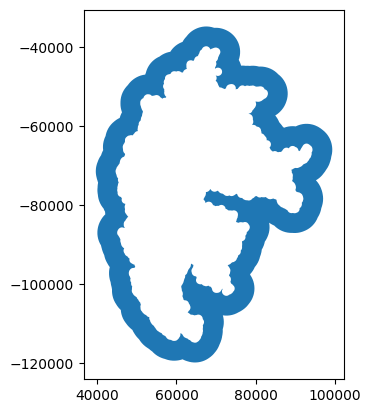

In [37]:
test_fire.get_buffer(5000, 1000).plot()

<Axes: >

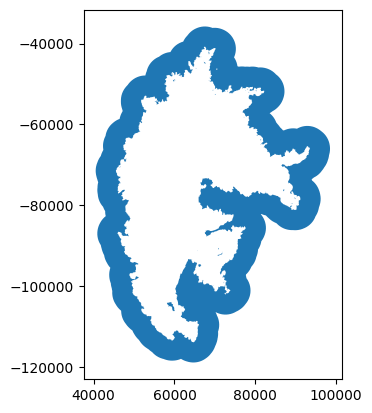

In [38]:
test_fire.get_buffer(5000, 100).plot()

<Axes: >

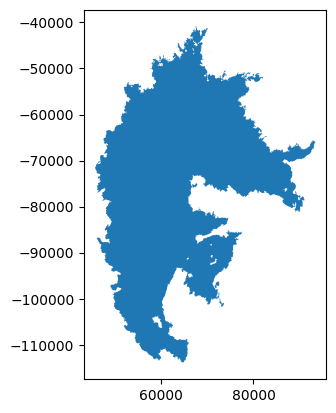

In [24]:
test_fire.fire.plot()

<Axes: >

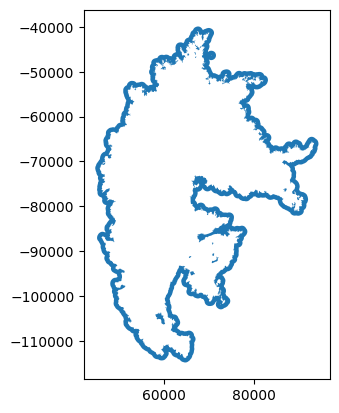

In [25]:
test_fire.fire_buffer.plot()

In [16]:
test_fire_2 = Fire(firep[firep.index==241])

<Axes: >

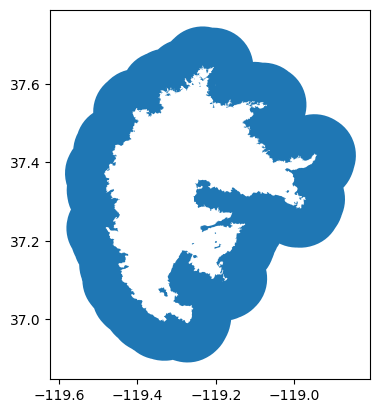

In [17]:
test_fire_2.fire_buffer.plot()

<Axes: >

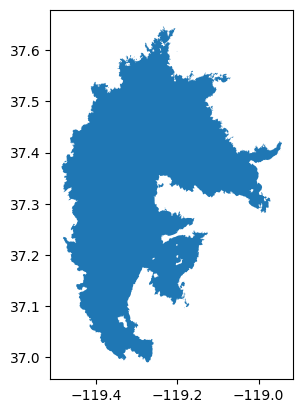

In [8]:
firep[firep.index==241].plot()

In [4]:
gedi_burned, gedi_unburned = gedi_pipeline.stage_5_filter_for_regrowth_l4a_sierras(3, save=True)

2023-06-10 00:47:52,765 DEBUG: Read in intermediate data from stage 3. [in stage_4_filter_burns_l4a_sierras at /home/jk871/fire-regen/src/data/gedi_pipeline.py:189]
2023-06-10 00:48:24,121 DEBUG: Filter burn areas. [in stage_4_filter_burns_l4a_sierras at /home/jk871/fire-regen/src/data/gedi_pipeline.py:193]
2023-06-10 00:48:25,268 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9178162 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:230]
2023-06-10 00:48:25,521 DEBUG: Number of GEDI shots that burned at least once:                  1262136 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:235]
2023-06-10 00:48:26,519 DEBUG: Number of GEDI shots that never burned since 1984:         7829875 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:242]
2023-06-10 00:48:26,864 DEBUG: Number of shots that burned exactly once:                 

In [184]:
gedi_lc = gedi_pipeline.match_land_cover_on_burned_regions(gedi_burned)

2017
41240
1
41240
2


EEException: Collection query aborted after accumulating over 5000 elements.

In [182]:
gedi_burned.burn_year_median.astype('int').unique()

array([2017, 1996, 2004, 1995, 2015, 1991, 1985, 2001, 2018, 2020, 1984,
       1988, 1999, 2019, 2012, 2006, 1987, 2011, 2007, 1992, 2016, 1994,
       2008, 1990, 2013, 2000, 2003, 1986, 2009, 1997, 1998, 2005, 2014,
       2010, 2021, 2002, 1989, 1993])

In [146]:
land_cover = lcms_import.get_lcms('2017', '2018').first()

In [174]:
from src.data import ee_utils
fc = ee_utils.gedi_coordinates_to_feature_collection(gedi_burned.head(10000))

10000


In [152]:
res = land_cover.reduceRegions(collection = fc, reducer = ee.Reducer.median(), scale =30, crs = "EPSG:4326")

In [154]:
fcs_res = res.getInfo()

In [159]:
[x['properties']['median'] for x in fcs_res['features']]

[10,
 10,
 4,
 4,
 4,
 4,
 10,
 4,
 4,
 4,
 4,
 4,
 10,
 4,
 4,
 10,
 10,
 4,
 10,
 4,
 4,
 4,
 4,
 10,
 4,
 4,
 4,
 10,
 4,
 4,
 4,
 10,
 4,
 4,
 4,
 10,
 4,
 10,
 4,
 4,
 4,
 10,
 10,
 10,
 4,
 10,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 10,
 4,
 4,
 4,
 10,
 4,
 4,
 10,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 10,
 4,
 4,
 10,
 4,
 10,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [148]:
gedi_burned.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
firep = sierra_firep.perimeters.dropna(subset=['ALARM_DATE', 'CONT_DATE', 'FIRE_NAME'])
firep = firep[firep.FIRE_NAME != 'W-4 TERMO']
firep = firep[firep.FIRE_NAME != 'BEALE2']

In [82]:
firep.shift()

YEAR_ STATE AGENCY UNIT_ID      FIRE_NAME   INC_NUM  \
0      None  None   None    None           None      None   
2      2020    CA    CDF     NEU         NELSON  00013212   
3      2020    CA    CDF     NEU         ATHENS  00018493   
4      2020    CA    CDF     NEU        FLEMING  00007619   
6      2020    CA    CDF     NEU       MELANESE  00008471   
...     ...   ...    ...     ...            ...       ...   
21671  2021    CA    CDF     MMU      MANZANITA  00001330   
21672  2021    CA    USF     SQF       BOYDEN 1  00000401   
21674  2021    CA    USF     INF  GLACIER NORTH  00001732   
21684  2021    CA    CDF     BTU          DIXIE  00009205   
21687  2008    CA    USF     SNF           STAR  00000715   

                      ALARM_DATE                  CONT_DATE  CAUSE  \
0                           None                       None    NaN   
2      2020-06-18T00:00:00+00:00  2020-06-23T00:00:00+00:00   11.0   
3      2020-08-10T00:00:00+00:00  2020-03-01T00:00:00+00:00   14.0   
4      2020-03-31T00:00:00+00:00  2020-04-01T00:00:00+00:00    9.0   
6      2020-04-14T00:00:00+00:00  2020-04-19T00:00:00+00:00   18.0   
...                          ...                        ...    ...   
21671  2021-01-19T00:00:00+00:00  2021-01-19T00:00:00+00:00    5.0   
21672  2021-03-03T00:00:00+00:00  2021-03-18T00:00:00+00:00    5.0   
21674  2021-07-15T00:00:00+00:00  2021-08-20T00:00:00+00:00    1.0   
21684  2021-07-14T00:00:00+00:00  2021-10-25T00:00:00+00:00   11.0   
21687  2008-06-21T00:00:00+00:00  2008-07-14T00:00:00+00:00    1.0   

                                                COMMENTS  ...      GIS_ACRES  \
0                                                   None  ...            NaN   
2                                                         ...     109.602280   
3                                                         ...      27.300480   
4                                                         ...      12.931545   
6                                                         ...      10.315964   
...                                                  ...  ...            ...   
21671                                                NaN  ...      22.377903   
21672               D7E40363-FBF7-48F9-89B1-949414CBE236  ...      14.573442   
21674               021BB0CC-3981-4987-9F5B-BEED4DEC902E  ...      37.255802   
21684  E9DB628D-DFB7-4C85-BCD6-1254574D946B, contains...  ...  963405.437500   
21687                                                NaN  ...     267.612793   

       C_METHOD  OBJECTIVE  FIRE_NUM  Shape_Length    Shape_Area  \
0           NaN        NaN      None           NaN           NaN   
2           1.0        1.0      None  3.252523e+03  4.435447e+05   
3           1.0        1.0      None  1.649643e+03  1.104811e+05   
4           1.0        1.0      None  1.577156e+03  5.233211e+04   
6           1.0        1.0      None  1.035788e+03  4.174722e+04   
...         ...        ...       ...           ...           ...   
21671       1.0        1.0       NaN  1.843027e+03  9.056016e+04   
21672       6.0        1.0       NaN  9.276290e+02  5.897663e+04   
21674       6.0        1.0       NaN  2.334983e+03  1.507689e+05   
21684       7.0        1.0       NaN  1.533820e+06  3.898763e+09   
21687       8.0        1.0  00000018  1.586997e+04  1.082991e+06   

         COMPLEX_NAME COMPLEX_INCNUM  \
0                None           None   
2                None           None   
3                None           None   
4                None           None   
6                None           None   
...               ...            ...   
21671             NaN            NaN   
21672             NaN            NaN   
21674             NaN            NaN   
21684             NaN            NaN   
21687  SILVER COMPLEX       00000715   

                                                geometry  FID  
0                                                   None  NaN  
2      MULTIPOLYGON (((-121.34840 38.88999, -

In [119]:
lala = regen_analysis.process_all_fires(firep.head(20), gedi_burned)

Processing fire NELSON and 0
No matches for fire NELSON.
Processing fire ATHENS and 2
No matches for fire ATHENS.
Processing fire FLEMING and 3
No matches for fire FLEMING.
Processing fire MELANESE and 4
No matches for fire MELANESE.
Processing fire VALLEY and 6
No matches for fire VALLEY.
Processing fire WALDO and 7
No matches for fire WALDO.
Processing fire WILLOW and 8
No matches for fire WILLOW.
Processing fire WILLOWS and 9
Processing fire FIELDS and 12
No matches for fire FIELDS.
Processing fire JONES and 13
Processing fire PAVE PAWS and 14
No matches for fire PAVE PAWS.
Processing fire RIOSA and 15
No matches for fire RIOSA.
Processing fire NELSON and 16
No matches for fire NELSON.
Processing fire 5-4 POTTERS  and 17
Processing fire 5-6 CASCADE CREEK and 18
Processing fire TEDDY and 19
No matches for fire TEDDY.
Processing fire AVOCADO and 35
No matches for fire AVOCADO.
Processing fire HONCUT and 36
No matches for fire HONCUT.
Processing fire GRAND and 37
No matches for fire GR

In [120]:
lala

shot_number   longitude   latitude        agbd  \
1526889   182910000200061325 -121.319421  39.373183   42.775154   
1526918   189510600300522748 -121.313858  39.380575   22.625639   
1526919   189510600300522750 -121.312808  39.379926   37.451229   
1526923   189510800300283001 -121.326087  39.378406   31.786558   
1526927   189510800300283019 -121.316793  39.372681   93.312050   
...                      ...         ...        ...         ...   
16199446  189470500200058965 -121.191407  39.694001   20.301390   
16199447  189470500200058966 -121.190899  39.694309   23.415890   
16199453  189470600200479324 -121.192701  39.686099   52.400318   
16199457  189470600200479340 -121.184029  39.691371  111.140900   
16199465  217240100200058323 -121.193045  39.695855   79.815910   

          agbd_pi_lower  agbd_pi_upper    agbd_se beam_type  sensitivity  \
1526889        1.116268     144.576752  11.104338  coverage     0.967988   
1526918    -9999.000000     104.885262  11.108277      full     0.973055   
1526919        0.404463     134.641403  11.104465      full     0.971589   
1526923        0.023711     123.697350  11.105305      full     0.973808   
1526927       17.449068     229.293015  11.099771      full     0.973646   
...                 ...            ...        ...       ...          ...   
16199446   -9999.000000      99.821571  11.110950      full     0.971666   
16199447   -9999.000000     106.587669  11.110002      full     0.979234   
16199453       3.068996     161.944916  11.117362      full     0.965346   
16199457      25.600080     256.801392  11.100086      full     0.953214   
16199465      11.905885     207.863174  11.103322  coverage     0.955578   

          pft_class  ...    GIS_ACRES  C_METHOD OBJECTIVE FIRE_NUM  \
1526889           1  ...  1309.089966       3.0       1.0      NaN   
1526918           1  ...  1309.089966       3.0       1.0      NaN   
1526919           1  ...  1309.089966       3.0       1.0      NaN   
1526923           1  ...  1309.089966       3.0       1.0      NaN   
1526927           1  ...  1309.089966       3.0       1.0      NaN   
...             ...  ...          ...       ...       ...      ...   
16199446          1  ...   260.175568       1.0       1.0      NaN   
16199447          1  ...   260.175568       1.0       1.0      NaN   
16199453          1  ...   260.175568       1.0       1.0      NaN   
16199457          1  ...   260.175568       1.0       1.0      NaN   
16199465          1  ...   260.175568       1.0       1.0      NaN   

          Shape_Length    Shape_Area             COMPLEX_NAME  COMPLEX_INCNUM  \
1526889   11758.463918  5.297699e+06                      NaN             NaN   
1526918   11758.463918  5.297699e+06                      NaN             NaN   
1526919   11758.463918  5.297699e+06                      NaN             NaN   
1526923   11758.463918  5.297699e+06                      NaN             NaN   
1526927   11758.463918  5.297699e+06                      NaN             NaN   
...                ...           ...                      ...             ...   
16199446   5399.386327  1.052893e+06  BUTTE LIGHTNING COMPLEX        00009692   
16199447   5399.386327  1.052893e+06  BUTTE LIGHTNING COMPLEX        00009692   
16199453   5399.386327  1.052893e+06  BUTTE LIGHTNING COMPLEX        00009692   
16199457   5399.386327  1.052893e+06  BUTTE LIGHTNING COMPLEX        00009692   
16199465   5399.386327  1.052893e+06  BUTTE LIGHTNING COMPLEX        00009692   

          FID distance_to_perimeter  
1526889     0            496.020639  
1526918     0            149.969932  
1526919     0             73.533785  
1526923     0            362.854501  
1526927     0            268.868995  
...       ...                   ...  
16199446    0             93.660468  
16199447    0             38.283620  
16199453    0            120.206668  
16199457    0             22.316580  
16199465    0             39.752214  

[188 rows x 40 columns]

In [115]:
koko[:, 0] = [1, 1, 3, 3, 3]
koko[:, 1] = [2, 2, 2, 2, 2]
koko[:, 2] = [5, 0, 1, -2, 8]

In [117]:
koko.min(axis=1)

array([ 1.,  0.,  1., -2.,  2.])

In [104]:
len(list(firep[firep.index == 9].geometry.iloc[0].geoms))

1

In [99]:
firep[firep.index == 9].geometry.iloc[0].geoms

In [79]:
lala[lala.distance_to_perimeter != 0]

Empty GeoDataFrame
Columns: [shot_number, longitude, latitude, agbd, agbd_pi_lower, agbd_pi_upper, agbd_se, beam_type, sensitivity, pft_class, gedi_year, gedi_month, absolute_time, geometry, burn_severity_median, burn_year_median, burn_counts_median, time_since_burn, index_right, YEAR_, STATE, AGENCY, UNIT_ID, FIRE_NAME, INC_NUM, ALARM_DATE, CONT_DATE, CAUSE, COMMENTS, REPORT_AC, GIS_ACRES, C_METHOD, OBJECTIVE, FIRE_NUM, Shape_Length, Shape_Area, COMPLEX_NAME, COMPLEX_INCNUM, FID, distance_to_perimeter]
Index: []

[0 rows x 40 columns]

In [31]:
Fire(firep[(firep.FIRE_NAME == 'INGALLS') & (firep.INC_NUM == 'nan')])

IndexError: single positional indexer is out-of-bounds

In [37]:
firep[(firep.FIRE_NAME == 'NIAGARA')]

YEAR_ STATE AGENCY UNIT_ID FIRE_NAME INC_NUM                 ALARM_DATE  \
809  2007    CA    USF     STF   NIAGARA     NaN  2007-08-09T00:00:00+00:00   

                     CONT_DATE  CAUSE  COMMENTS  ...   GIS_ACRES  C_METHOD  \
809  2007-08-09T00:00:00+00:00    4.0  20090305  ...  161.385284       1.0   

     OBJECTIVE  FIRE_NUM Shape_Length     Shape_Area  COMPLEX_NAME  \
809        1.0  00000043  6541.828268  653103.057119           NaN   

    COMPLEX_INCNUM                                           geometry FID  
809            NaN  MULTIPOLYGON (((-119.90510 38.32955, -119.9049...   0  

[1 rows x 21 columns]

In [27]:
firep[(firep.FIRE_NAME == 'SALT') & (firep.INC_NUM == '00009353')].ALARM_DATE.iloc[0]

'2020-08-18T00:00:00+00:00'

In [39]:
for perimeter in firep.itertuples():
    print(perimeter.Index)

0
2
3
4
6
7
8
9
12
13
14
15
16
17
18
19
35
36
37
42
43
44
48
49
56
57
58
59
60
61
74
75
77
78
79
80
82
88
89
121
122
123
126
127
128
129
130
132
134
136
138
141
142
143
145
146
147
149
227
228
229
230
231
232
235
236
237
238
240
241
244
245
248
251
256
257
260
261
262
280
284
285
286
290
294
295
296
304
305
308
310
311
312
314
317
318
322
323
324
325
327
328
329
330
331
332
333
334
335
336
340
341
346
347
370
373
375
380
382
420
424
482
483
484
485
486
487
488
509
514
523
524
525
526
564
565
578
580
581
584
585
586
590
591
593
594
595
596
600
601
604
605
609
610
611
612
614
615
618
619
620
621
622
623
628
629
630
631
632
633
634
638
639
640
641
645
647
650
664
669
671
676
681
688
689
690
692
693
694
695
696
697
698
699
706
707
708
712
732
733
734
735
736
738
741
742
743
744
745
748
749
752
757
759
762
766
770
771
772
774
779
780
791
793
794
801
803
804
806
807
808
809
810
811
814
815
816
817
819
820
821
843
852
853
854
855
857
879
880
881
882
883
884
885
886
891
892
893
894
897
900
901

In [41]:
firep[firep.index == 2]

YEAR_ STATE AGENCY UNIT_ID FIRE_NAME   INC_NUM                 ALARM_DATE  \
2  2020    CA    CDF     NEU    ATHENS  00018493  2020-08-10T00:00:00+00:00   

                   CONT_DATE  CAUSE COMMENTS  ...  GIS_ACRES  C_METHOD  \
2  2020-03-01T00:00:00+00:00   14.0           ...   27.30048       1.0   

   OBJECTIVE  FIRE_NUM Shape_Length     Shape_Area  COMPLEX_NAME  \
2        1.0       NaN  1649.643235  110481.125253           NaN   

  COMPLEX_INCNUM                                           geometry FID  
2            NaN  MULTIPOLYGON (((-121.33333 38.84558, -121.3331...   0  

[1 rows x 21 columns]